<!--TABLE OF CONTENTS-->
<b>Contents:</b>
- [1. Определение стоимости автомобилей](#1.-Определение-стоимости-автомобилей)
  - [1.1. Импорты](#1.1.-Импорты)
  - [1.2. Загрузка данных](#1.2.-Загрузка-данных)
  - [1.3. Анализ данных](#1.3.-Анализ-данных)
  - [1.4. Подготовка данных](#1.4.-Подготовка-данных)
    - [1.4.1. Целевой признак](#1.4.1.-Целевой-признак)
    - [1.4.2. Константные и незначимые признак](#1.4.2.-Константные-и-незначимые-признак)
    - [1.4.3. Разбиение данных на обучающую и тестовую выборки](#1.4.3.-Разбиение-данных-на-обучающую-и-тестовую-выборки)
    - [1.4.4. Обработка пропусков](#1.4.4.-Обработка-пропусков)
    - [1.4.5. Аномалии/выбросы](#1.4.5.-Аномалии/выбросы)
    - [1.4.6. Postal code - регионы](#1.4.6.-Postal-code---регионы)
    - [1.4.7. Годовой пробег автомобиля](#1.4.7.-Годовой-пробег-автомобиля)
    - [1.4.8. Извлечение циклических данных из datetime](#1.4.8.-Извлечение-циклических-данных-из-datetime)
    - [1.4.9. Анализ данных для обучения после обработки](#1.4.9.-Анализ-данных-для-обучения-после-обработки)
  - [1.5. Pipeline](#1.5.-Pipeline)
    - [1.5.1. Кастомные классы и функции](#1.5.1.-Кастомные-классы-и-функции)
    - [1.5.2. Сборка пайплайна](#1.5.2.-Сборка-пайплайна)
  - [1.6. Обучение моделей](#1.6.-Обучение-моделей)
    - [1.6.1. Проверка модели на адекватность](#1.6.1.-Проверка-модели-на-адекватность)
    - [1.6.2. LGBMRegressor](#1.6.2.-LGBMRegressor)
    - [1.6.3. DecisionTreeRegressor](#1.6.3.-DecisionTreeRegressor)
    - [1.6.4. LinearRegression](#1.6.4.-LinearRegression)
    - [1.6.5. RandomForestRegressor](#1.6.5.-RandomForestRegressor)
  - [1.7. Анализ моделей](#1.7.-Анализ-моделей)
    - [1.7.1. Ускорение LightGBM Regressor](#1.7.1.-Ускорение-LightGBM-Regressor)
    - [1.7.2. Качество модели на тестовых данных](#1.7.2.-Качество-модели-на-тестовых-данных)
  - [1.8. Выводы](#1.8.-Выводы)

# 1. Определение стоимости автомобилей

<div class="Markdown base-markdown base-markdown_with-gallery markdown markdown_size_normal markdown_type_theory full-markdown"><h2>Описание проекта</h2> Построить модель, которая предсказывает рыночную стоимость  автомобиля. </div><div class="paragraph"> В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.</div><div class="paragraph">Критерии, которые важны заказчику:</div><ul><li>качество предсказания;</li><li>время обучения модели;</li><li>время предсказания модели.</li></ul><h3>Инструкция по выполнению проекта</h3><div class="paragraph">Примечания:</div><ul><li>Для оценки качества моделей применяйте метрику&nbsp;RMSE.</li><li>Значение метрики&nbsp;RMSE&nbsp;должно быть меньше 2500.</li></ul><h3>Описание данных</h3>
<div class="paragraph"><strong>Признаки</strong></div><ul><li><em>DateCrawled</em> — дата скачивания анкеты из базы</li><li><em>VehicleType</em> — тип автомобильного кузова</li><li><em>RegistrationYear</em> — год регистрации автомобиля</li><li><em>Gearbox</em> — тип коробки передач</li><li><em>Power</em> — мощность (л. с.)</li><li><em>Model</em> — модель автомобиля</li><li><em>Kilometer</em> — пробег (км)</li><li><em>RegistrationMonth</em> — месяц регистрации автомобиля</li><li><em>FuelType</em> — тип топлива</li><li><em>Brand</em> — марка автомобиля</li><li><em>Repaired</em> — была машина в ремонте или нет</li><li><em>DateCreated</em> — дата создания анкеты</li><li><em>NumberOfPictures</em> — количество фотографий автомобиля</li><li><em>PostalCode</em> — почтовый индекс владельца анкеты (пользователя)</li><li><em>LastSeen</em> — дата последней активности пользователя</li></ul><div class="paragraph"><strong>Целевой признак</strong></div><div class="paragraph"><em>Price</em> — цена (евро)</div>

In [1]:
try:
    %load_ext lab_black
except:
    "no lab_black"

## 1.1. Импорты

In [2]:
#!pip install pandas-profiling

In [3]:
!pip install lightgbm

In [4]:
!pip install feature-engine

In [5]:
!pip install sweetviz

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

#from pandas_profiling import ProfileReport
import sweetviz

from feature_engine.imputation import (
    DropMissingData,
    AddMissingIndicator,
    CategoricalImputer,
)
from feature_engine.selection import DropFeatures
from feature_engine.creation import MathFeatures
from feature_engine.encoding import DecisionTreeEncoder
from feature_engine.outliers import OutlierTrimmer, Winsorizer

from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    StandardScaler,
    PowerTransformer,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import mean_squared_error, make_scorer

## 1.2. Загрузка данных

Загрузим и изучим данные:

In [7]:
data = pd.read_csv("/datasets/autos.csv")
data_original = data.copy()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Переименуем названия колонок из CamelCase в snake_case:

In [9]:
data.columns = [re.sub(r"(?<!^)(?=[A-Z])", "_", name).lower() for name in data.columns]
print(data.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


## 1.3. Анализ данных

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

Преобразуем date поля к datetime типу:

In [11]:
data["date_crawled"] = pd.to_datetime(data["date_crawled"], infer_datetime_format=True)
data["date_created"] = pd.to_datetime(data["date_created"], infer_datetime_format=True)
data["last_seen"] = pd.to_datetime(data["last_seen"], infer_datetime_format=True)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [13]:
data.head(10)

date_crawled  price vehicle_type  registration_year gearbox  power  \
0 2016-03-24 11:52:17    480          NaN               1993  manual      0   
1 2016-03-24 10:58:45  18300        coupe               2011  manual    190   
2 2016-03-14 12:52:21   9800          suv               2004    auto    163   
3 2016-03-17 16:54:04   1500        small               2001  manual     75   
4 2016-03-31 17:25:20   3600        small               2008  manual     69   
5 2016-04-04 17:36:23    650        sedan               1995  manual    102   
6 2016-04-01 20:48:51   2200  convertible               2004  manual    109   
7 2016-03-21 18:54:38      0        sedan               1980  manual     50   
8 2016-04-04 23:42:13  14500          bus               2014  manual    125   
9 2016-03-17 10:53:50    999        small               1998  manual    101   

     model  kilometer  registration_month fuel_type       brand repaired  \
0     golf     150000                   0    petrol  volkswagen      NaN   
1      NaN     125000                   5  gasoline        audi      yes   
2    grand     125000                   8  gasoline        jeep      NaN   
3     golf     150000                   6    petrol  volkswagen       no   
4    fabia      90000                   7  gasoline       skoda       no   
5      3er     150000                  10    petrol         bmw      yes   
6  2_reihe     150000                   8    petrol     peugeot       no   
7    other      40000                   7    petrol  volkswagen       no   
8    c_max      30000                   8    petrol        ford      NaN   
9     golf     150000                   0       NaN  volkswagen      NaN   

  date_created  number_of_pictures  postal_code           last_seen  
0   2016-03-24                   0        70435 2016-04-07 03:16:57  
1   2016-03-24                   0        66954 2016-04-07 01:46:50  
2   2016-03-14                   0        90480 2016-04-05 12:47:46  
3   2016-03-17                   0        91074 2016-03-17 17:40:17  
4   2016-03-31                   0        60437 2016-04-06 10:17:21  
5   2016-04-04                   0        33775 2016-04-06 19:17:07  
6   2016-04-01                   0        67112 2016-04-05 18:18:39  
7   2016-03-21                   0        19348 2016-03-25 16:47:58  
8   2016-04-04                   0        94505 2016-04-04 23:42:13  
9   2016-03-17                   0        27472 2016-03-31 17:17:06

                                             |                                              | [  0%]   00:00 -…


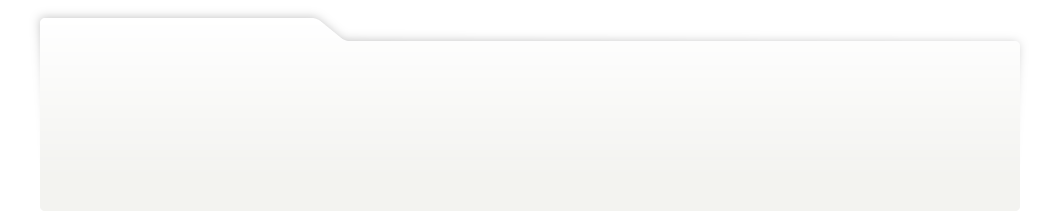
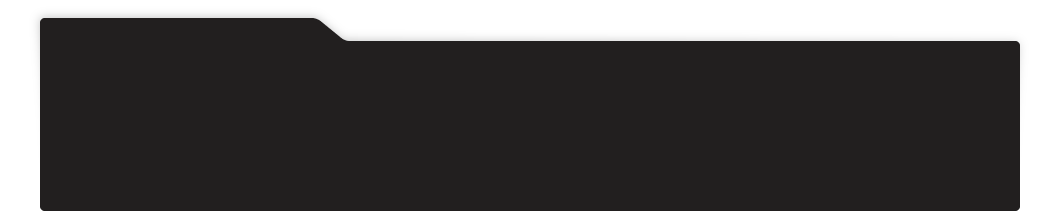
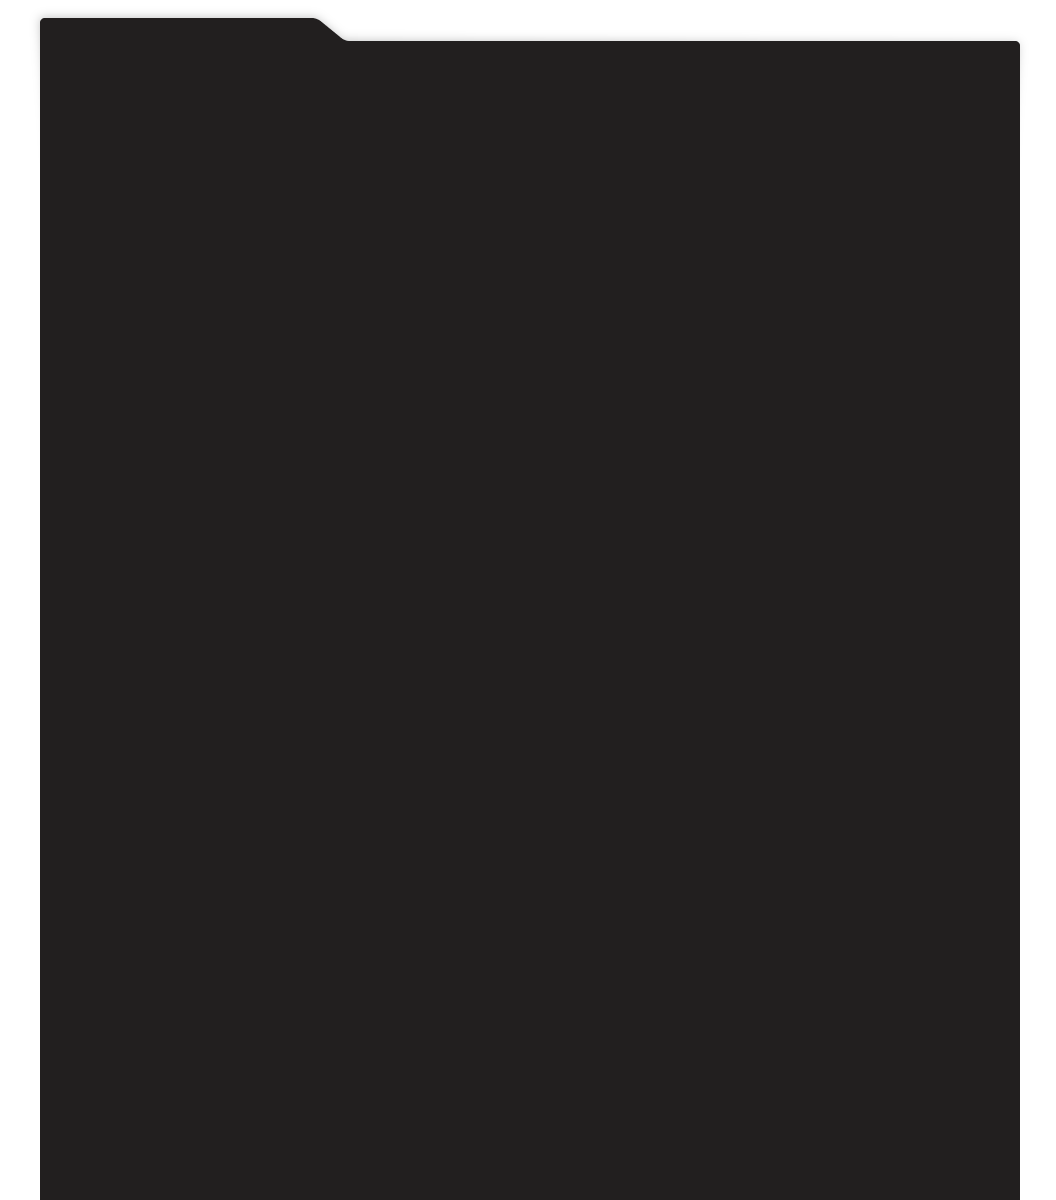
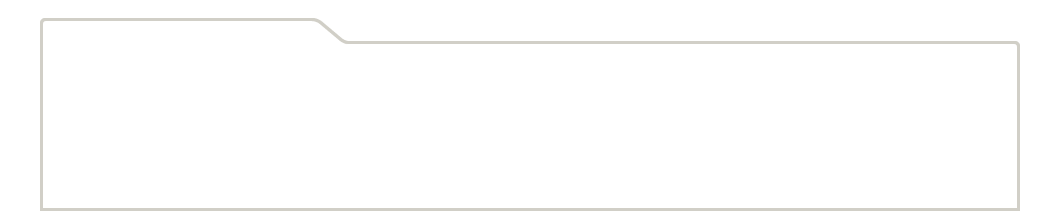
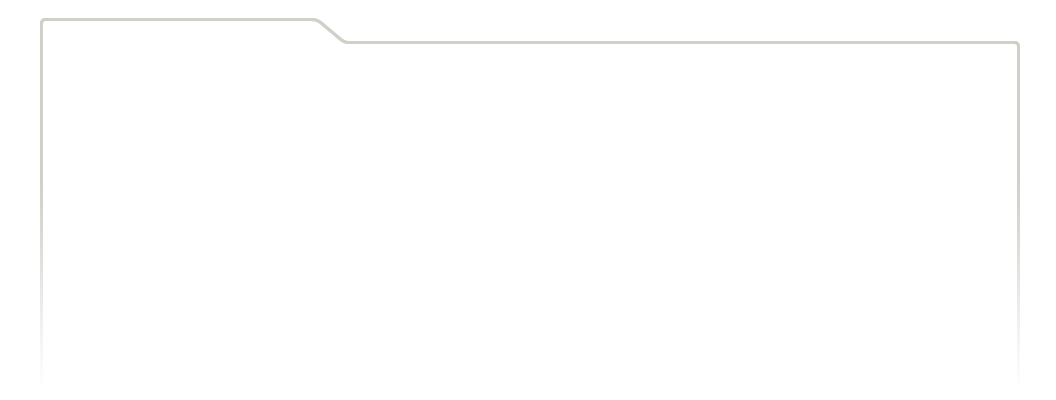
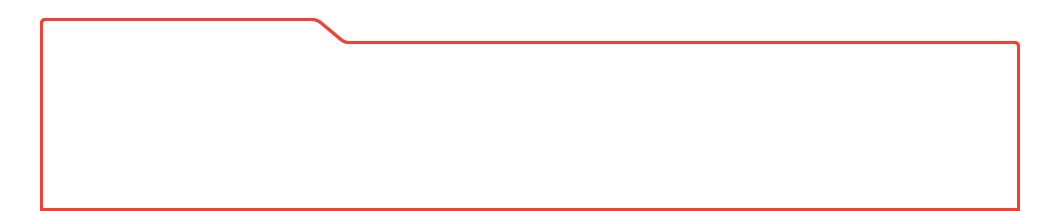
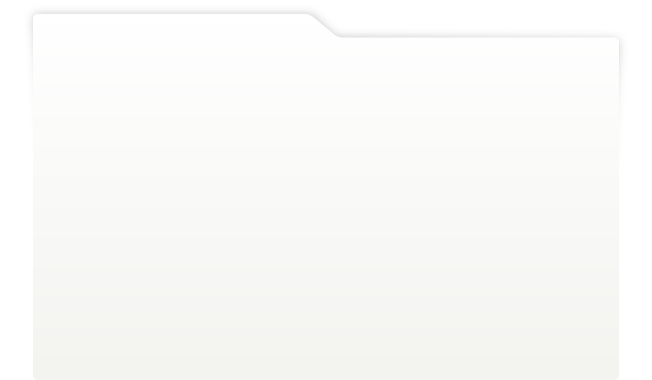
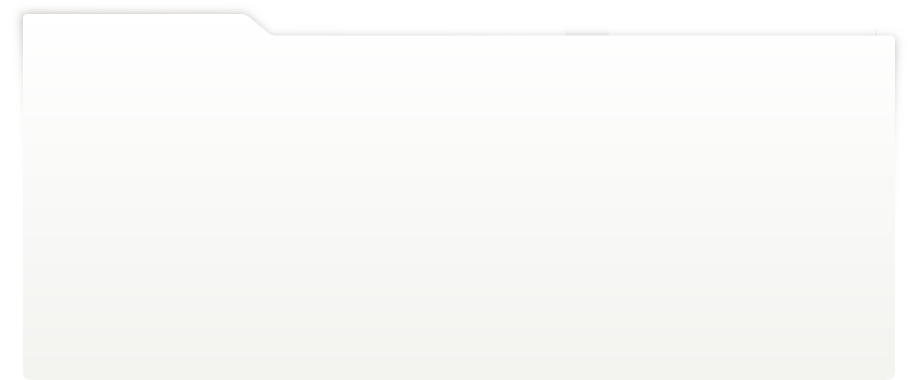
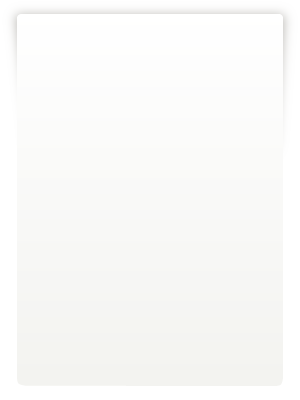
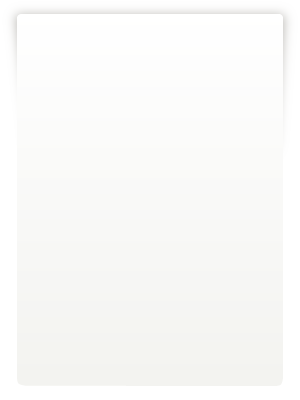
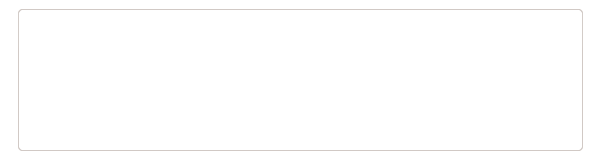
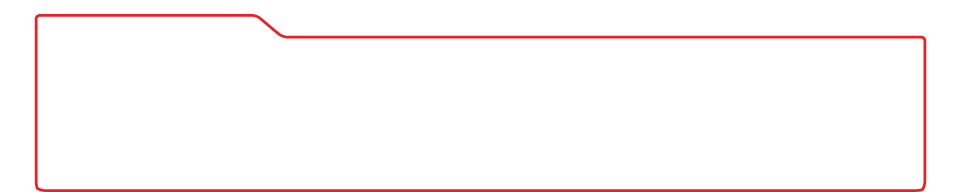
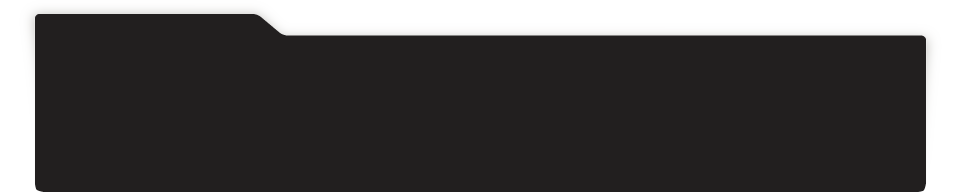
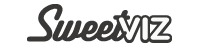
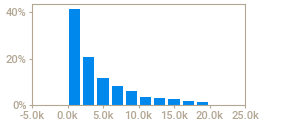
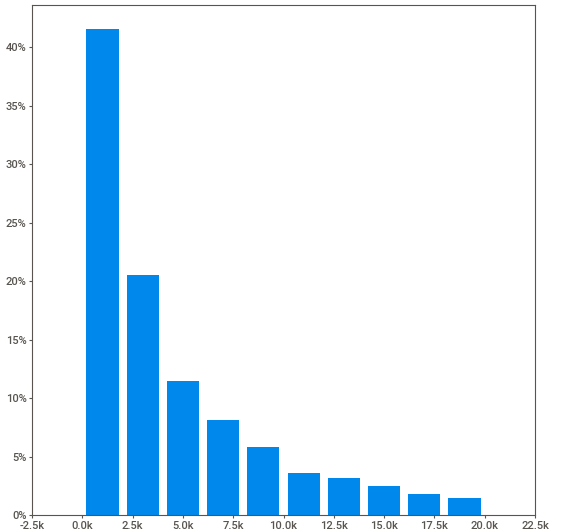
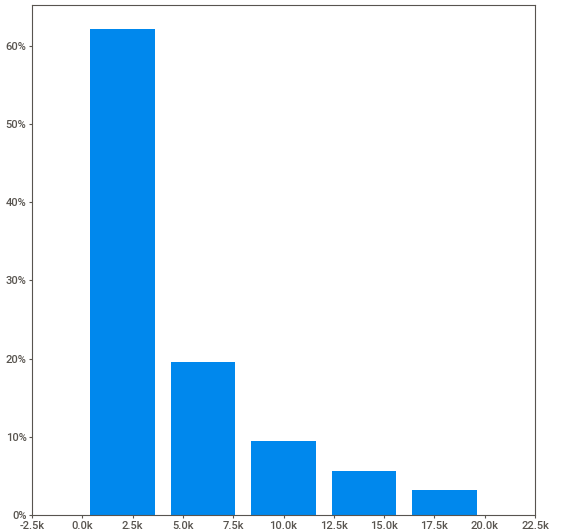
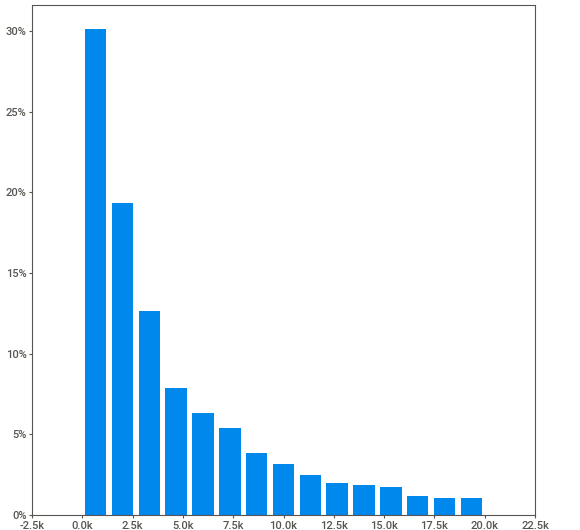
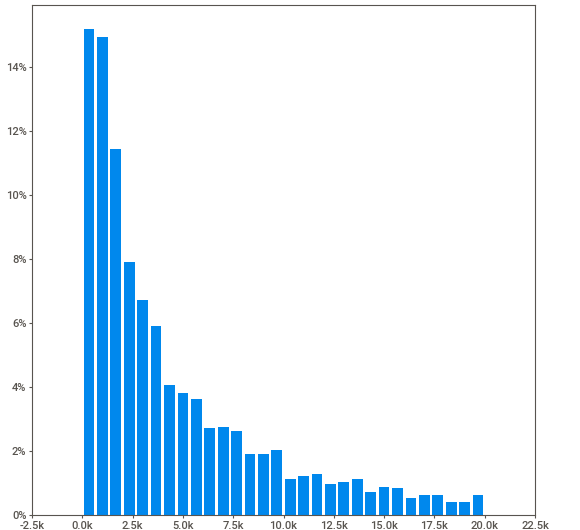
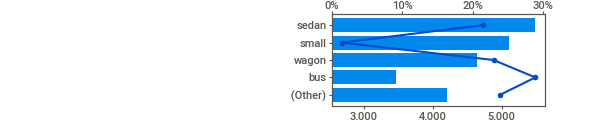
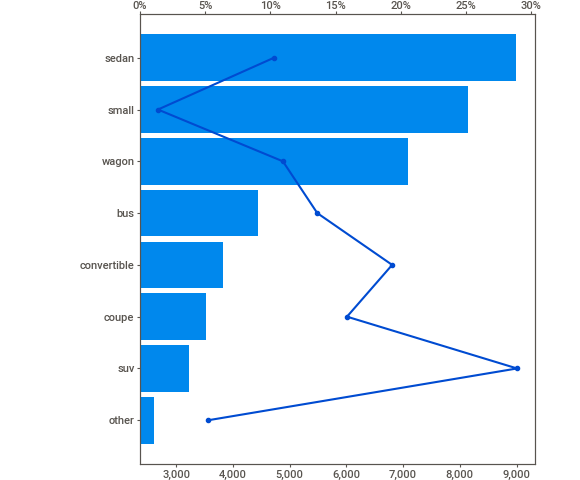
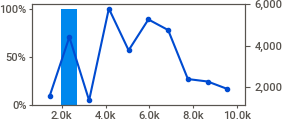
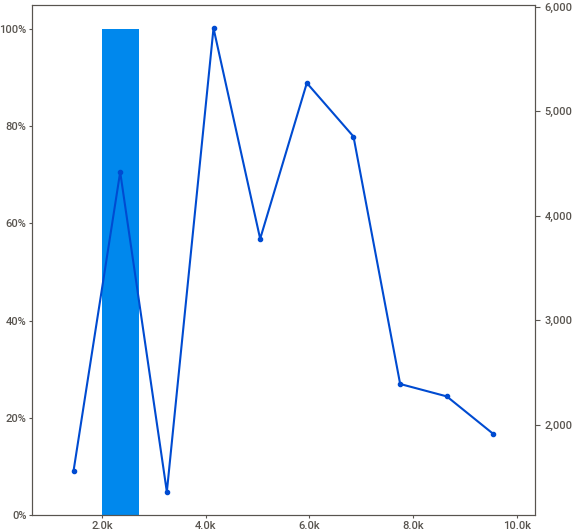
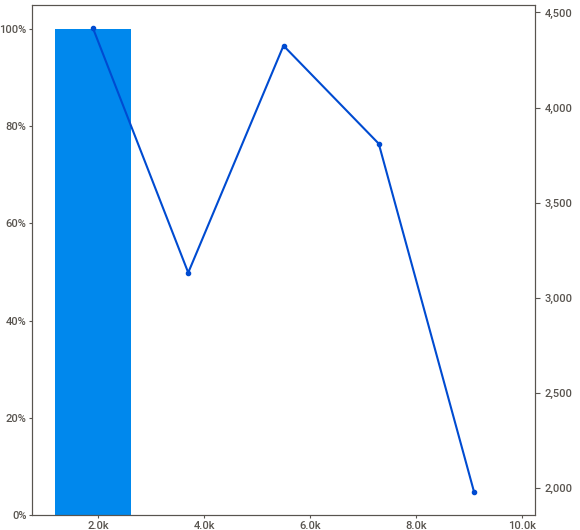
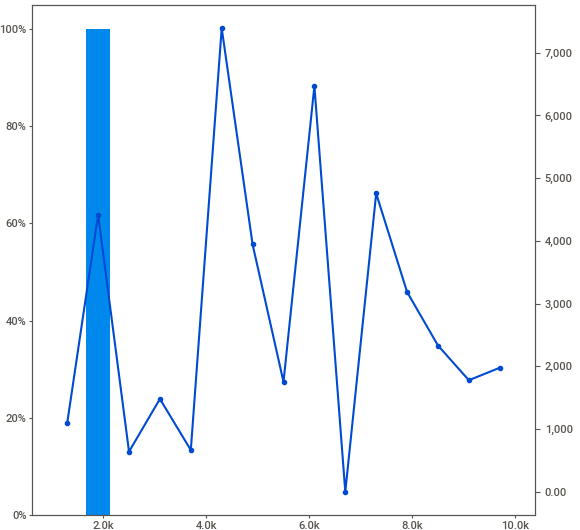
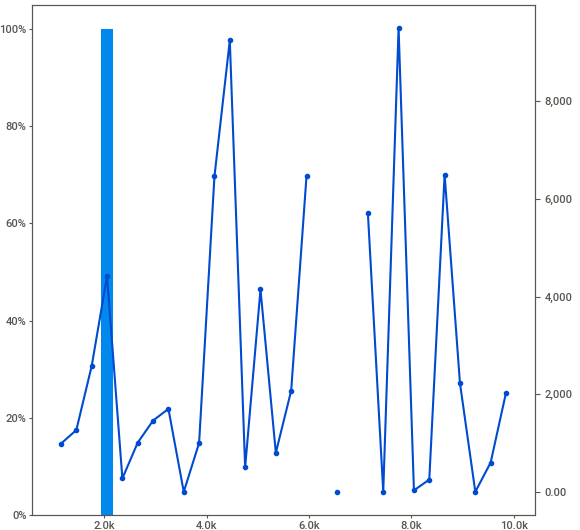
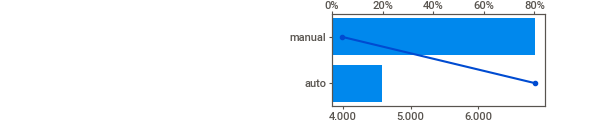
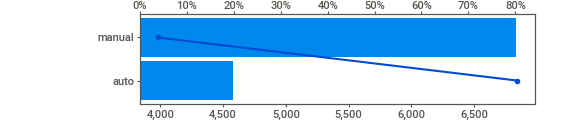
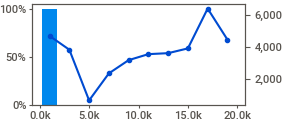
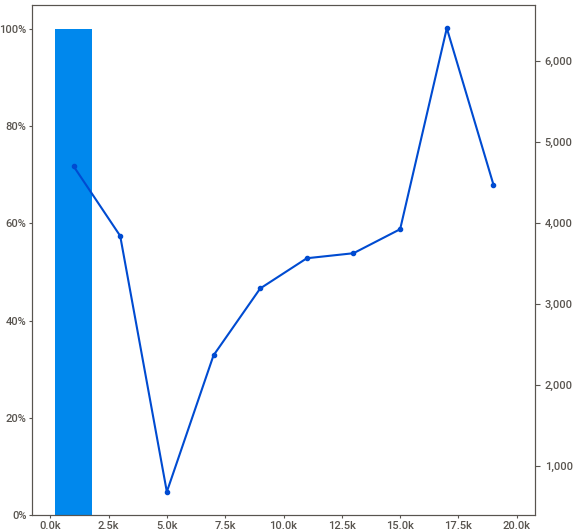
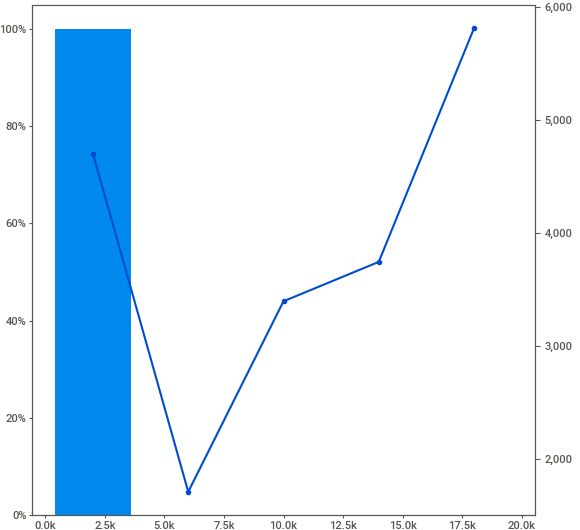
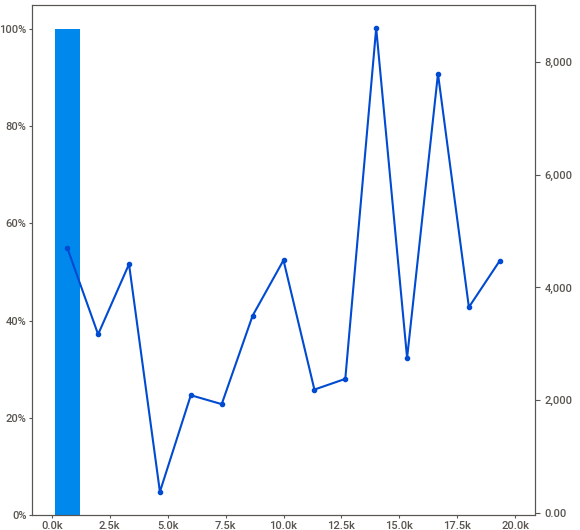
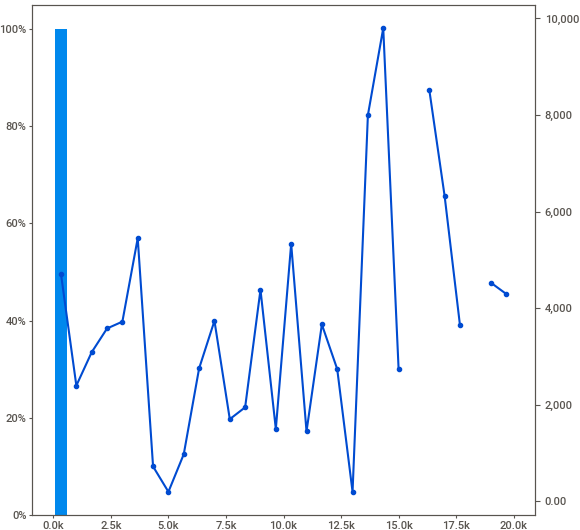
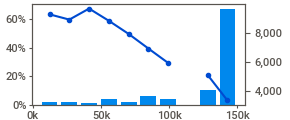
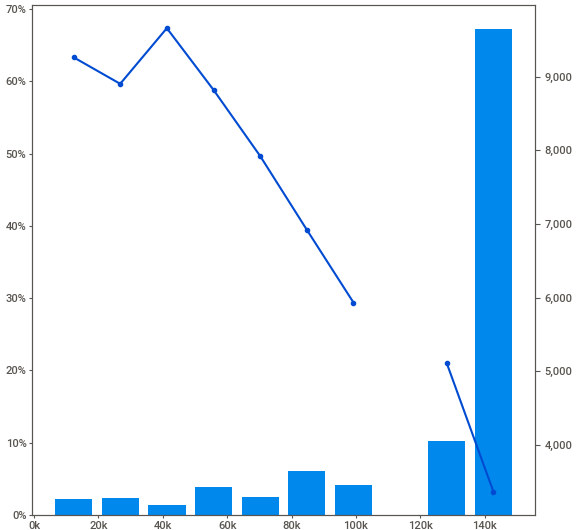
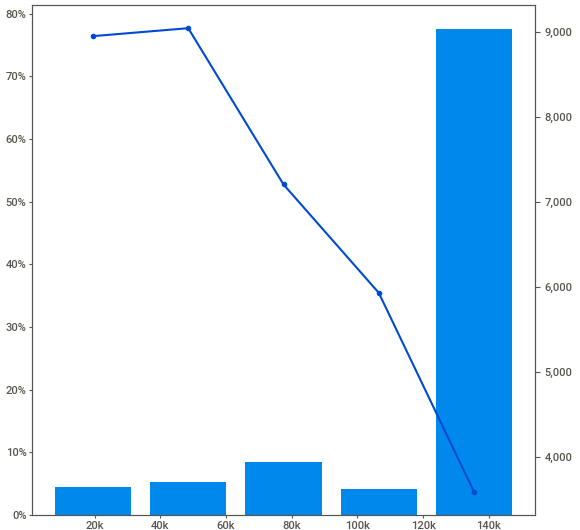
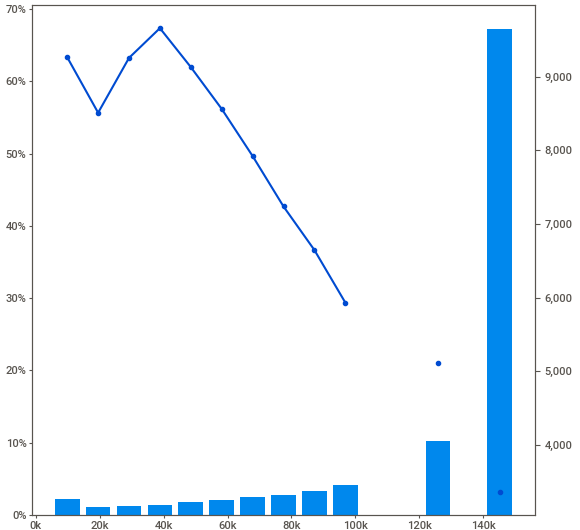
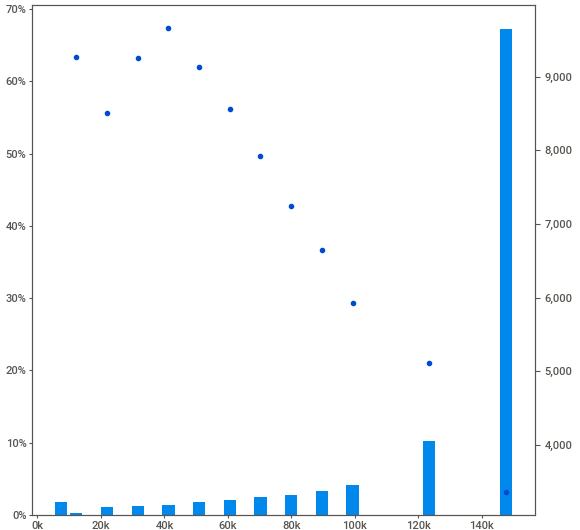
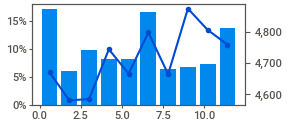
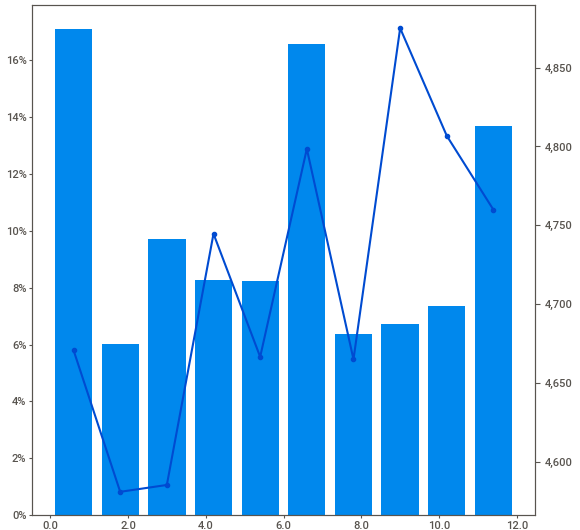
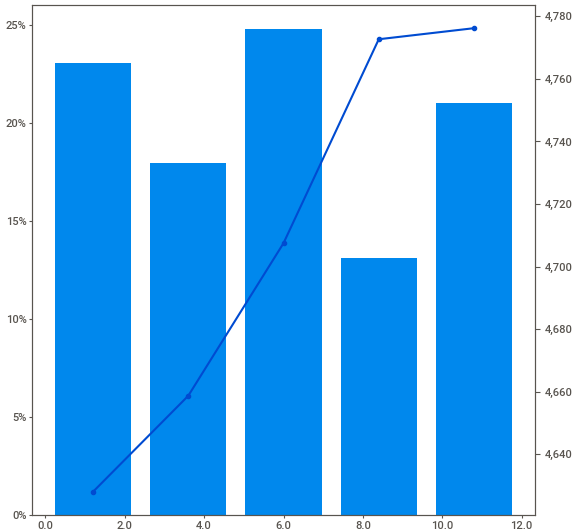
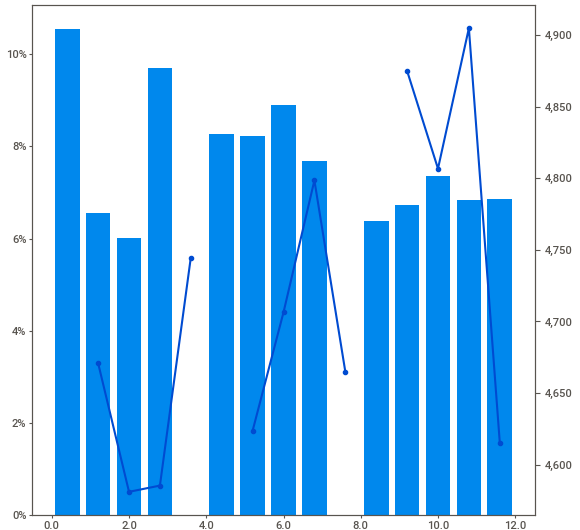
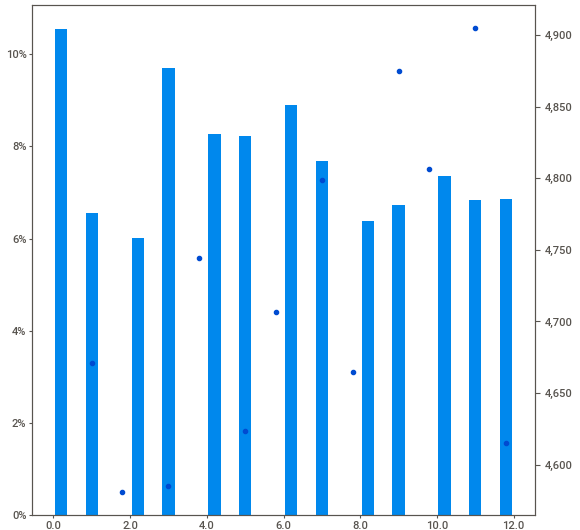
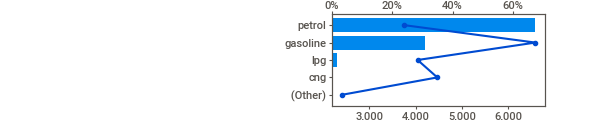
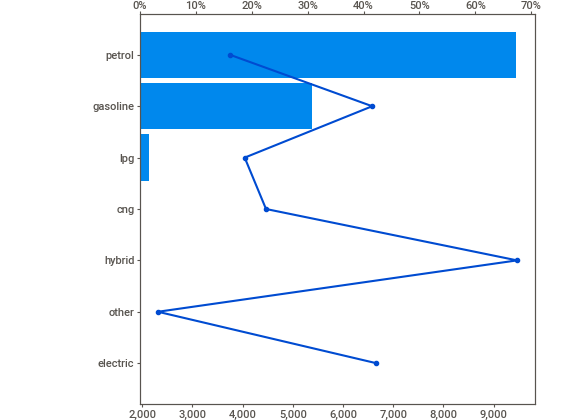
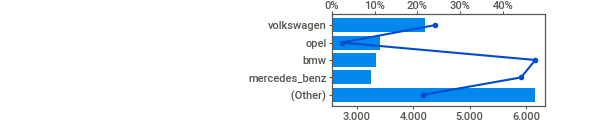
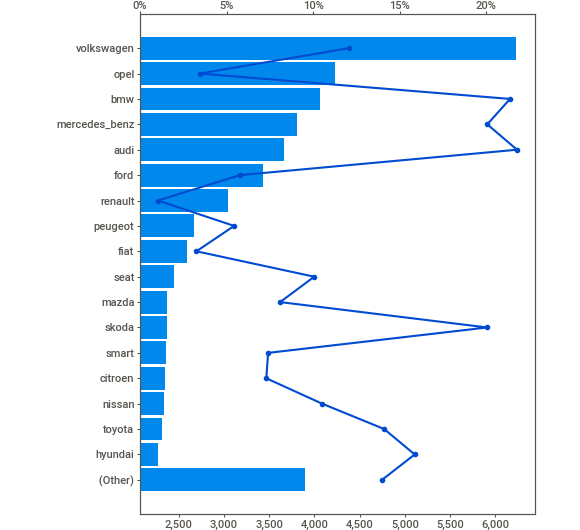
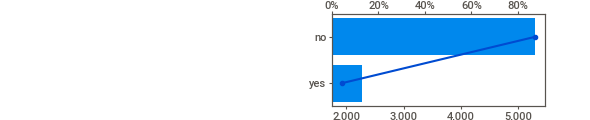
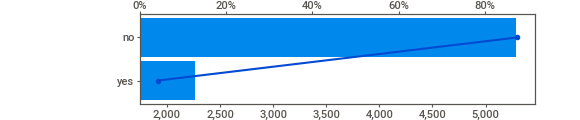
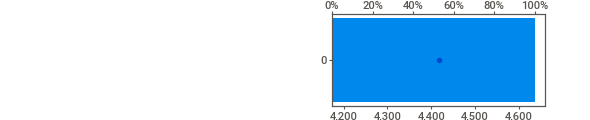
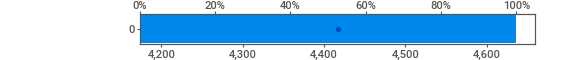
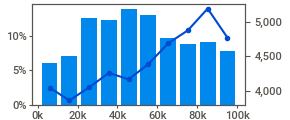
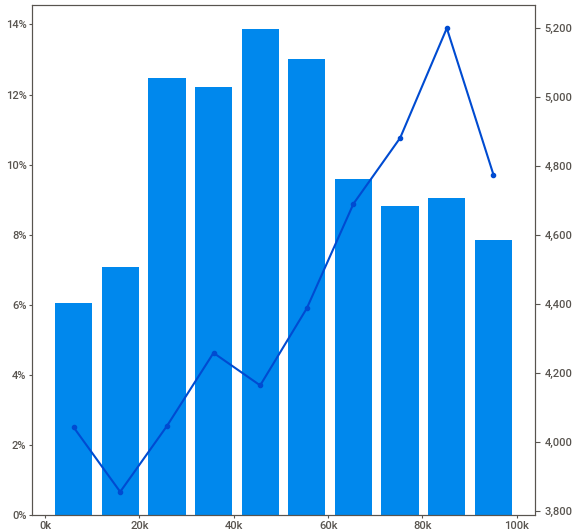
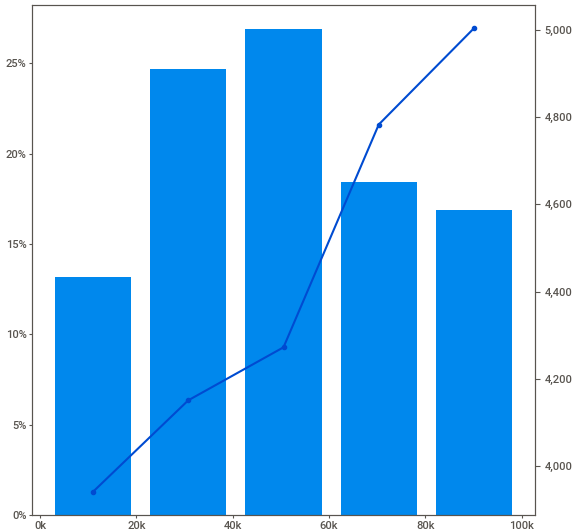
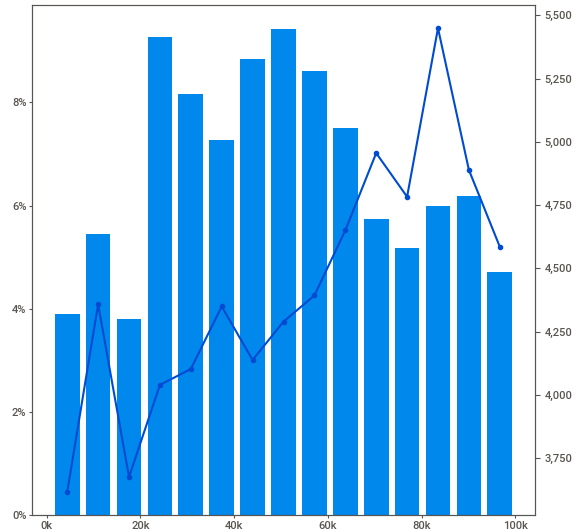
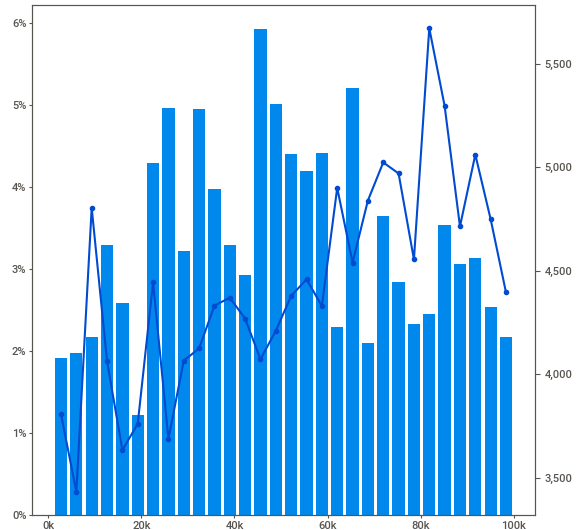
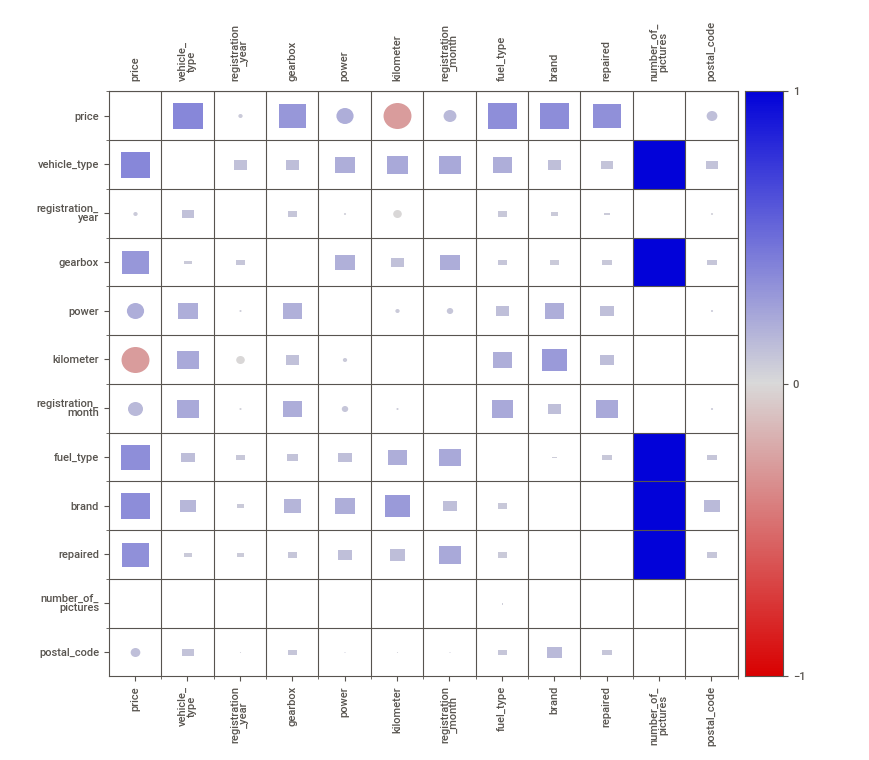
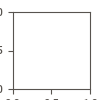

In [15]:
full_report = sweetviz.analyze(data, "price")
full_report.show_notebook()

В EDA отчетах видим, что: 
* number_of_pictures - всегда равна 0
* большое число пропусков в repaired, vehicle_type, fuel_type, gearbox, model
    * в repaired имеет смысл сохранить информацию о пропусках - так как это говорит о том, что возможно машина ремонтировалась, но данных об этом нет
    * vehicle_type, fuel_type, gearbox, model - можно попробовать восстановить из  присутствующей информации
* аномальные значения (9999,1000) в registration_year
* аномально высокие значения в power (похоже на неверные меры величины)
* нули в price и power - видимо, тоже пропуски в данных
* в registration_date - 13 уникальных значений, будем считать, что начало года (0) и конец года (12) - специально выделенные значения, т.к. при продаже автомобилей с нового года к возрасту автомобиля прибавляют год, будь он даже выпущен в конце года.
* самые сильные свяи с ценой - у vehicle_type, brand, fuel_type, repaired, gearbox, kilometer
* километраж дискретизирован по 5к километров
* данные скачивались в течение месяца date_crawled с 2016-03-05 по 2016-04-07
* date_created имеет всего 109 уникальных значений (только дата, без времени) и в основном распределен в те же даты, что и даты скачивания анкет
* в last_seen имеется гораздо больше уникальных значений в отличие от date_created, в том числе потому что в нем есть данные по  времени, а также здесь гораздо больше значений, лежаших в диапазоне до дат скачивания анкет

Построим ящики с усами для признаков, чтобы увидеть наличие выбросов:

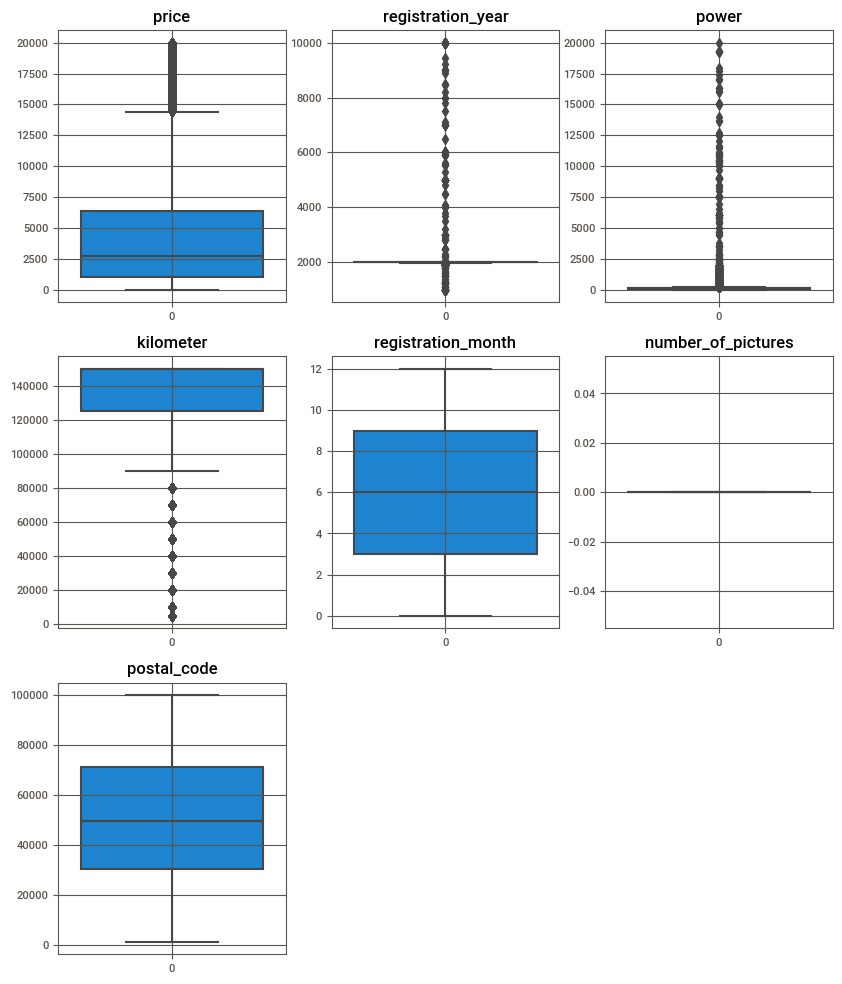

In [16]:
fig, ax = plt.subplots(3, 3, figsize=(10, 12))
ax = ax.flatten()
for i, col in enumerate(
    data.select_dtypes(exclude=["object", "datetime64[ns]"]).columns
):
    sns.boxplot(data=data[col], ax=ax[i])
    ax[i].grid()
    ax[i].set_title(col)
    max_i = i
for i in range(max_i + 1, len(ax)):
    fig.delaxes(ax[i])
plt.show()

Видим выбросы вверх по цене (оставим как есть, это могут быть эксклюзивные авто, например), различные аномальные значения - выбросы у registration year (их обработаем), выбросы в power - скорее всего, неверные величины, в kilometer - выбросы вниз - это, скорее всего, редкие небольшие пробеги у автомобилей.

## 1.4. Подготовка данных

### 1.4.1. Целевой признак

Нули в целевом признаке имеет смысл удалить и из обучающего и тестового набора данных - так как по условиям задачи, нам необходимо предсказывать рыночную стоимость автомобиля, а нулевая цена в данном случае - ошибочные данные и "0" - будет бессмысленным предсказанием .

В том числе есть нулевые цены для большого набора данных без пропусков:

In [17]:
data[(data["price"] == 0) & (data[data["price"] == 0].isna().sum(axis=1) == 0)].count()

date_crawled          3386
price                 3386
vehicle_type          3386
registration_year     3386
gearbox               3386
power                 3386
model                 3386
kilometer             3386
registration_month    3386
fuel_type             3386
brand                 3386
repaired              3386
date_created          3386
number_of_pictures    3386
postal_code           3386
last_seen             3386
dtype: int64

Удаляем из датасета нулевые цены:

In [18]:
data = data.drop(index=data[data["price"] == 0].index).reset_index(drop=True)

### 1.4.2. Константные и незначимые признак

Удалим NumberOfPictures:

In [19]:
data = data.drop("number_of_pictures", axis=1)

### 1.4.3. Разбиение данных на обучающую и тестовую выборки

Прежде чем проводить следующие преобразования данных разобьем данные применив `train_test_split(...)`:
* обучающая - 80% строк
* тестовая - 20% строк

In [20]:
data_train, data_test = train_test_split(data, test_size=0.2, random_state=19_12_22)
print("Total records count:", data.shape[0])
print("Train records count:", data_train.shape[0])
print("Test records count:", data_test.shape[0])

Total records count: 343597
Train records count: 274877
Test records count: 68720


Скопируем data_train в data_train_original, чтобы иметь необработанную копию данных для обучения

In [21]:
data_train_original = data_train.copy()

### 1.4.4. Обработка пропусков

In [22]:
data_train.isna().sum().sort_values(ascending=False)

repaired              52598
vehicle_type          27113
fuel_type             23618
model                 14095
gearbox               13867
date_crawled              0
price                     0
registration_year         0
power                     0
kilometer                 0
registration_month        0
brand                     0
date_created              0
postal_code               0
last_seen                 0
dtype: int64

Пропуски в repaired заменим в пайплайне на missing с помощью CategoricalImputer из библиотеки feature-engine.

In [23]:
cat_imputer = CategoricalImputer(variables=["repaired"])
data_train = cat_imputer.fit_transform(data_train)

Посмотрим на пересечение пропусков по столбцам (кроме repaired), выведем число пропусков в строке и процент от всех строк с таким числом пропусков:

In [24]:
na_and_zero_power_count = data_train[
    ["vehicle_type", "gearbox", "model", "fuel_type", "power"]
].isna().sum(axis=1) + (data_train.power == 0)
(na_and_zero_power_count).value_counts() / len(data_train) * 100

0    76.769610
1    13.084762
2     6.359208
3     2.163513
4     1.207813
5     0.415095
dtype: float64

Видим, что есть строки где все 5 из 5 значений пропущены (для полей имеющих пропуски или "0" для power) - от этих строк однозначно стоит избавиться

Посмотрим на наборы пропусков по полям vehicle_type, gearbox, model, fuel_type, power ("0" как пропуск) и их количество в датасете (выводим имена полей где есть пропуски):

In [25]:
data_train.loc[
    na_and_zero_power_count > 0,
    ["vehicle_type", "gearbox", "model", "fuel_type", "power"],
].apply(
    lambda x: tuple(
        [
            x.index[i] if pd.isna(col) or col == 0 else " " * len(x.index[i])
            for (i, col) in enumerate(x)
        ]
    ),
    axis=1,
).value_counts()

(            ,        ,      ,          , power)    12157
(vehicle_type,        ,      ,          ,      )     8325
(            ,        ,      , fuel_type,      )     6880
(            ,        , model,          ,      )     6107
(vehicle_type,        ,      , fuel_type,      )     5311
(vehicle_type,        ,      ,          , power)     3114
(            , gearbox,      ,          , power)     2951
(            , gearbox,      ,          ,      )     2498
(vehicle_type, gearbox,      , fuel_type, power)     2355
(            ,        ,      , fuel_type, power)     1478
(            ,        , model, fuel_type,      )     1332
(vehicle_type, gearbox, model, fuel_type, power)     1141
(vehicle_type, gearbox,      ,          , power)     1119
(vehicle_type,        , model, fuel_type,      )     1109
(vehicle_type,        ,      , fuel_type, power)     1106
(            ,        , model,          , power)     1032
(vehicle_type,        , model,          ,      )      854
(vehicle_type,

В train данных удалим строки:
* где больше 2-х пропусков - такие данные затруднительно восстановить с помощью какого-либо imputer-а
* где пересекаются пропуски в vehicle_type и model - здесь отсутствует слишком значимая информация
* где пересекаются пропуски в power и model - здесь тоже отсутствует слишком значимая информация


In [26]:
more_than_2_na_indexes = data_train[(na_and_zero_power_count > 2)].index
data_train = data_train.drop(
    data_train.query(
        "index in @more_than_2_na_indexes\
        or (vehicle_type.isna() and model.isna()) or (power==0 and model.isna())"
    ).index
)

In [27]:
na_and_zero_power_count.reindex()
data_train.loc[
    na_and_zero_power_count > 0,
    ["vehicle_type", "gearbox", "model", "fuel_type", "power"],
].apply(
    lambda x: tuple(
        [
            x.index[i] if pd.isna(col) or col == 0 else " " * len(x.index[i])
            for (i, col) in enumerate(x)
        ]
    ),
    axis=1,
).value_counts()

(            ,        ,      ,          , power)    12157
(vehicle_type,        ,      ,          ,      )     8325
(            ,        ,      , fuel_type,      )     6880
(            ,        , model,          ,      )     6107
(vehicle_type,        ,      , fuel_type,      )     5311
(vehicle_type,        ,      ,          , power)     3114
(            , gearbox,      ,          , power)     2951
(            , gearbox,      ,          ,      )     2498
(            ,        ,      , fuel_type, power)     1478
(            ,        , model, fuel_type,      )     1332
(vehicle_type, gearbox,      ,          ,      )      769
(            , gearbox,      , fuel_type,      )      432
(            , gearbox, model,          ,      )      207
dtype: int64

Можно выделить признаки для восстановления пропусков:
* vehicle_type, registration_year, gearbox, power, model, fuel_type, brand, price

Остальные признаки по своему смыслу не должны нести информации для восстановления пропущенных значений, возможно лишь только косвенную.

In [28]:
categorical = ["vehicle_type", "gearbox", "model", "fuel_type"]
informative_fields_not_to_encode = ["registration_year", "power", "price"]
informative_fields_to_encode = ["brand"]
informative_fields = informative_fields_not_to_encode + informative_fields_to_encode

Заменим пропуски во всех категориальных данных кроме model на значение "missing" (заглушку) с помощью CategoricalImputer:

In [29]:
cat_imputer = CategoricalImputer(variables=(list(set(categorical)-set(["model"]))))
data_train = cat_imputer.fit_transform(data_train)

In [30]:
ord_enc = OrdinalEncoder()
data_train[categorical + informative_fields_to_encode] = ord_enc.fit_transform(
    data_train[categorical + informative_fields_to_encode]
)

display(data_train)

date_crawled  price  vehicle_type  registration_year  gearbox  \
259582 2016-03-09 18:56:26    550           5.0               2000      2.0   
226494 2016-03-22 10:43:10   1500           5.0               1997      2.0   
119995 2016-03-09 12:56:10   1550           8.0               2001      1.0   
246709 2016-03-23 17:53:04    300           6.0               1995      2.0   
269155 2016-03-06 23:52:12   2699           6.0               2005      2.0   
...                    ...    ...           ...                ...      ...   
307177 2016-03-23 14:45:01   3500           6.0               2007      2.0   
98940  2016-04-03 12:45:08  14900           5.0               2012      2.0   
43725  2016-03-20 18:47:18  18500           2.0               2011      2.0   
111556 2016-03-26 09:38:44    400           8.0               2003      2.0   
245563 2016-03-24 14:58:01    999           5.0               1999      1.0   

        power  model  kilometer  registration_month  fuel_type  brand  \
259582    125  166.0     150000                  12        3.0   29.0   
226494     73   10.0     125000                   4        7.0   19.0   
119995    116   29.0     150000                   6        3.0    1.0   
246709     60   83.0     100000                  10        7.0   24.0   
269155     95  105.0     150000                   4        0.0   32.0   
...       ...    ...        ...                 ...        ...    ...   
307177     54  173.0     100000                   4        7.0   38.0   
98940     105  170.0      70000                  10        3.0   38.0   
43725     111   80.0      70000                   5        3.0   21.0   
111556    102  149.0     125000                  10        7.0   27.0   
245563    102   33.0     150000                   8        7.0   20.0   

       repaired date_created  postal_code           last_seen  
259582       no   2016-03-09        24116 2016-03-12 20:17:50  
226494       no   2016-03-22        25920 2016-04-03 21:15:54  
119995       no   2016-03-09        36043 2016-04-05 23:45:23  
246709      yes   2016-03-23        30926 2016-04-05 22:17:59  
269155       no   2016-03-06        21614 2016-04-07 08:44:55  
...         ...          ...          ...                 ...  
307177       no   2016-03-23        83022 2016-04-05 15:47:21  
98940        no   2016-04-03        33607 2016-04-07 14:57:29  
43725        no   2016-03-20        73230 2016-04-07 02:17:25  
111556  Missing   2016-03-26        86720 2016-03-26 09:38:44  
245563      yes   2016-03-24        14197 2016-04-01 10:19:08  

[262583 rows x 15 columns]

In [31]:
data_train.isna().sum()

date_crawled             0
price                    0
vehicle_type             0
registration_year        0
gearbox                  0
power                    0
model                 7646
kilometer                0
registration_month       0
fuel_type                0
brand                    0
repaired                 0
date_created             0
postal_code              0
last_seen                0
dtype: int64

Восстановим отдельно model с помощью одного ближайшего соседа (KNNImputer):

In [32]:
%%time
automodel_imputer = KNNImputer(n_neighbors=1)
data_train[categorical + informative_fields] = automodel_imputer.fit_transform(data_train[categorical + informative_fields])

CPU times: user 3min 18s, sys: 2min 38s, total: 5min 57s
Wall time: 1min 50s


Попытка использовать экспериментальный IterativeImputer для восстановления пропусков привела к переполнению памяти:

Этот IterativeImputer сработал на домашнем пк, но работал долго и прироста качества не дал
```python
%%time
imputer = IterativeImputer(
    estimator=LGBMClassifier(n_estimators=30),
    initial_strategy="most_frequent",
    max_iter=3,
    random_state=19_12_22,
)

data_train[categorical + informative_fields] = imputer.fit_transform(data_train[categorical + informative_fields])
```

### 1.4.5. Аномалии/выбросы

Избавимся от выбросов (удалим выбросы там где больше 1к автомобилей конкретной модели и обрежем там, где данных <1к) в power помодельно ( в том числе заменим "0"), там где меньше 20 строк - оставим как есть:

In [33]:
%%time
models_with_statistics = data_train["model"].value_counts()[
    data_train["model"].value_counts() > 20
]
remainder_model_list = (
    data_train["model"].value_counts()[data_train["model"].value_counts() <= 20].index
)
data_train_clipped = data_train.query("model in @remainder_model_list or model.isna()").copy()
for model in models_with_statistics.index:
    model_data = data_train.query("model==@model").copy()
    model_data.loc[model_data['power']==0,['power']]=model_data.query('power!=0')['power'].median()
    out_trimmer = OutlierTrimmer(tail="both", variables=["power"])
    out_clipper = Winsorizer(tail="both", variables=["power"])
    if models_with_statistics[model] > 1000:
        model_data = out_trimmer.fit_transform(model_data)
    else:
        model_data = out_clipper.fit_transform(model_data)
    # concat all models and the remainder
    data_train_clipped = pd.concat([data_train_clipped, model_data])

CPU times: user 6.56 s, sys: 140 ms, total: 6.7 s
Wall time: 6.69 s


In [34]:
data_train = data_train_clipped
data_train.shape

(262161, 15)

Так как power==0 считаем за пропуск, преобразуем этот признак временно во float, чтобы заменить оставшиеся нули на nan:

In [35]:
data_train["power"] = data_train["power"].apply(lambda x: x if x != 0 else np.nan)

In [36]:
%%time
power_imputer = KNNImputer(n_neighbors=1)
data_train[categorical + informative_fields] = power_imputer.fit_transform(data_train[categorical + informative_fields])

CPU times: user 1.16 s, sys: 2.72 s, total: 3.88 s
Wall time: 722 ms


In [37]:
data_train["power"] = data_train["power"].astype(int)

Восстановим значения категориальных признаков для наглядности и удобства дальнейшего анализа:

In [38]:
data_train[categorical + informative_fields_to_encode] = ord_enc.inverse_transform(
    data_train[categorical + informative_fields_to_encode]
)

Удалим строки с годами регистрации меньше 1970 г. и больше 2018 г. Все что было зарегистрировано раньше 1970 - это или ошибки в данных или единичные раритетные авто, где предсказывать цену затруднительно. Все что больше 2016 - тоже похоже на ошибки в данных.

In [39]:
data_train = data_train.drop(
    data_train.query("1970 > registration_year or registration_year > 2016").index
).reset_index(drop=True)
data_train.shape[0]

253104

### 1.4.6. Postal code - регионы

Для получения географической информации из поля postal_code извлечем регион продажи - за него обычно отвечают одна первая или первые две цифры (во всяком случае так сделано для Германии, данные по которой здесь предоставлены), причем результат будем хранить в строковом типе, так как первая цифра индекса может быть "0". Далее напишем кастомную функцию и будем использовать спецаильный класс для добавления этого признака в пайплайне.

In [40]:
postal_code_level_1 = (
    data["postal_code"]
    .astype("string")
    .apply(lambda str: str if len(str) == 5 else ("0" + str))
    .apply(lambda str: str[:2])
)
postal_code_level_1.value_counts().sort_values()

03     764
20     879
98     927
02    1080
19    1322
      ... 
44    6323
65    6907
66    6939
26    7327
45    8136
Name: postal_code, Length: 95, dtype: int64

In [41]:
postal_code_level_0 = (
    data["postal_code"]
    .astype("string")
    .apply(lambda str: str if len(str) == 5 else ("0" + str))
    .apply(lambda str: str[0])
)
postal_code_level_0.value_counts().sort_values()

0    17106
1    26433
9    26999
7    31046
8    31381
6    34364
2    41145
3    42091
5    45368
4    47664
Name: postal_code, dtype: int64

Сделаем копию data_train, чтобы добавить новые признаки вручную сейчас и проанализировать их с помощью sweetviz и pandas_profiling.

In [42]:
data_train_postprocessing = data_train.copy()

In [43]:
data_train_postprocessing["region_level_0"] = postal_code_level_0
data_train_postprocessing["region_level_1"] = postal_code_level_1

### 1.4.7. Годовой пробег автомобиля

Добавим в качестве нового признака годовой пробег авто разделив его общий  пробег на число лет прошедших с года регистрации registration_year до date_created:

In [44]:
yearly_km = (
    data_train["kilometer"]
    / (
        data_train["date_created"]
        - pd.to_datetime(data_train["registration_year"], format="%Y")
    ).dt.days
    * 365
).astype(int)
yearly_km

0         11935
1          8719
2         12182
3          1513
4          6859
          ...  
253099     4706
253100     7059
253101     4672
253102     4272
253103     4704
Length: 253104, dtype: int64

Добавим признак в копию data_train чтобы проанализировать его с помощью sweetviz и pandas_profiling:

In [45]:
data_train_postprocessing["yearly_km"] = yearly_km

### 1.4.8. Извлечение циклических данных из datetime

In [46]:
for field in ["date_crawled", "date_created", "last_seen"]:
    date = pd.to_datetime(data_train_postprocessing[field])
    data_train_postprocessing.loc[:, field + "_weekday"] = date.dt.weekday
    data_train_postprocessing.loc[:, field + "_monthday"] = date.dt.day
    data_train_postprocessing.loc[:, field + "_yearday"] = date.dt.dayofyear
    data_train_postprocessing.loc[:, field + "_hour"] = date.dt.hour

### 1.4.9. Анализ данных для обучения после обработки

                                             |                                              | [  0%]   00:00 -…


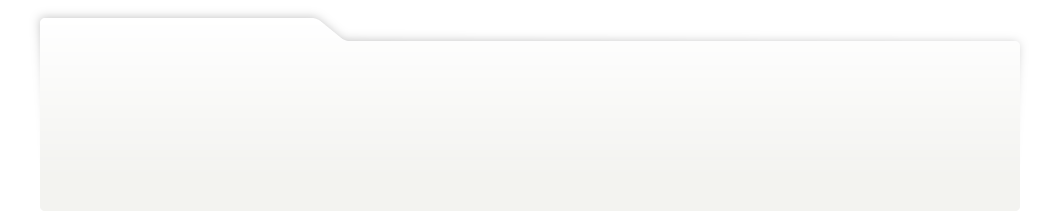
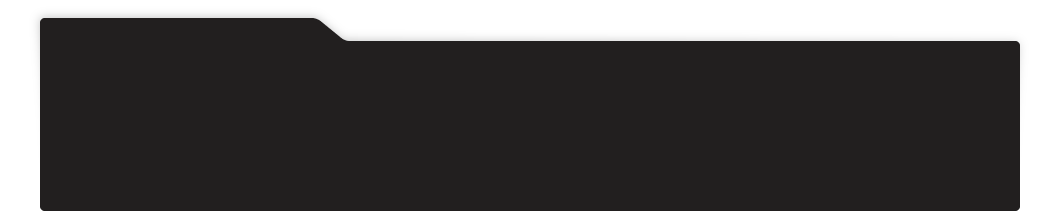
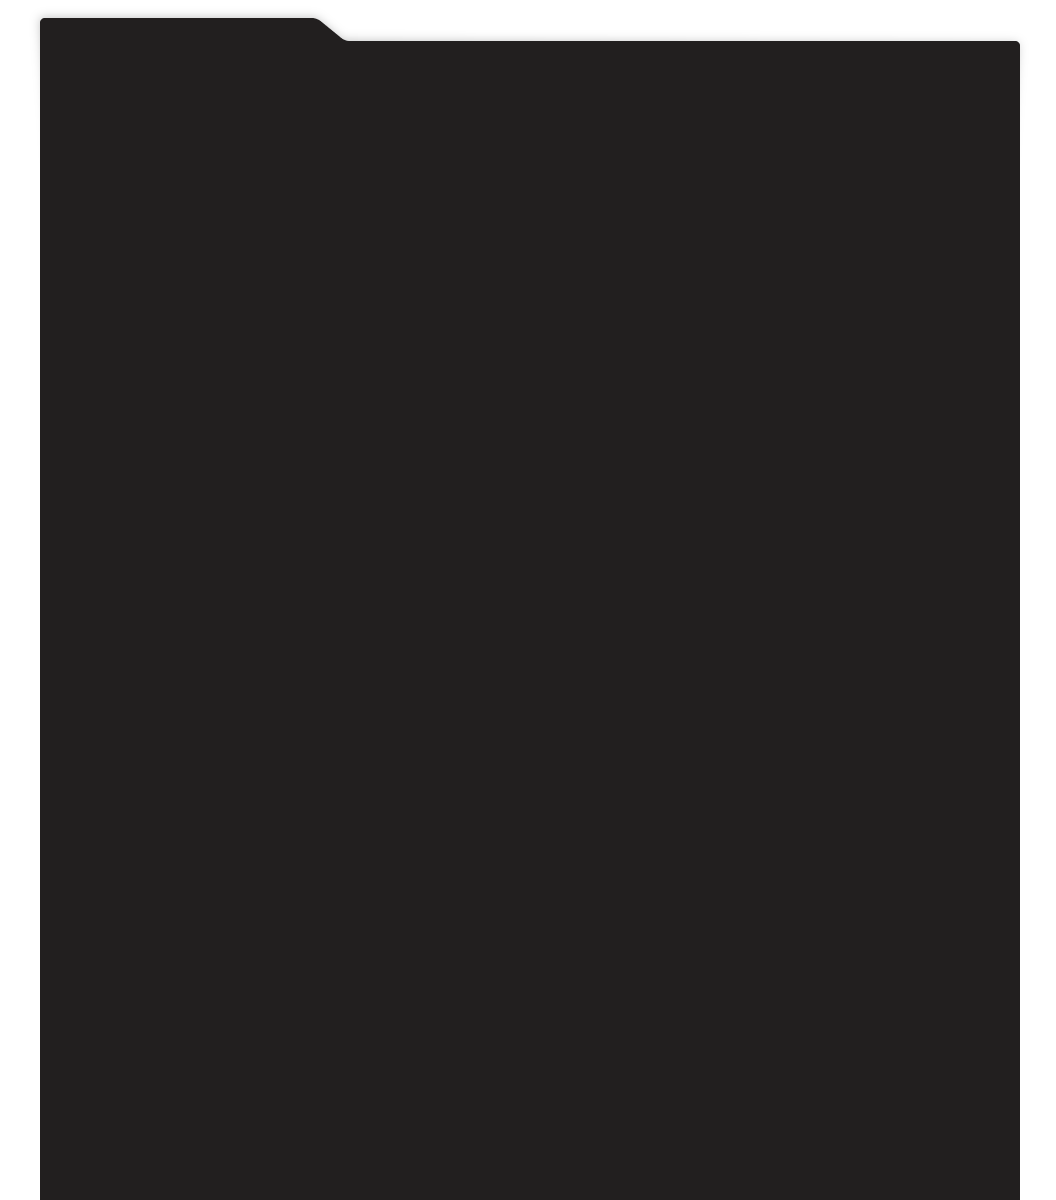
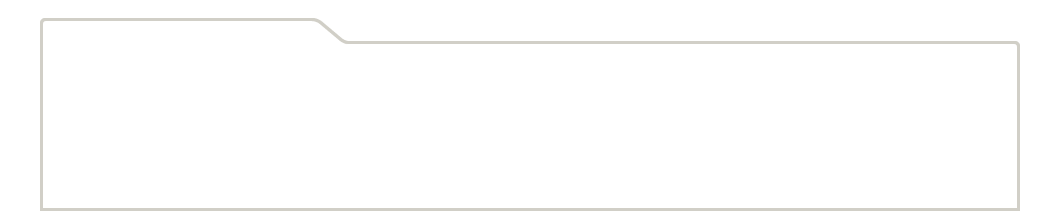
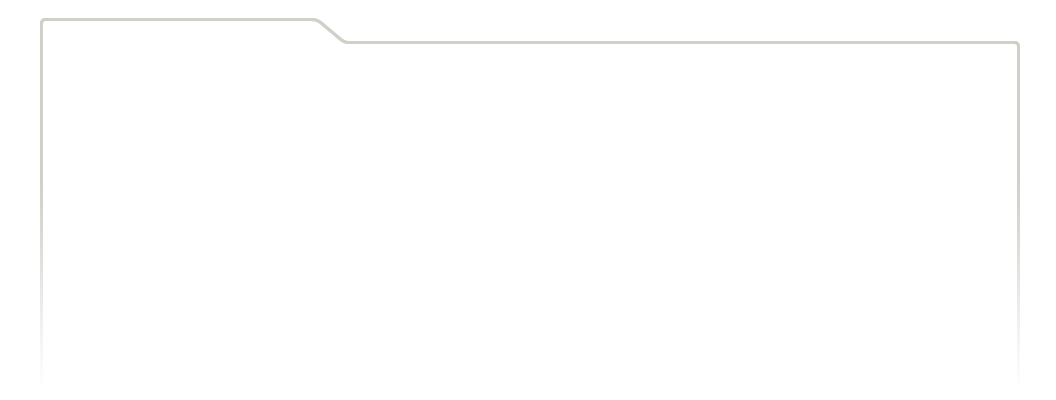
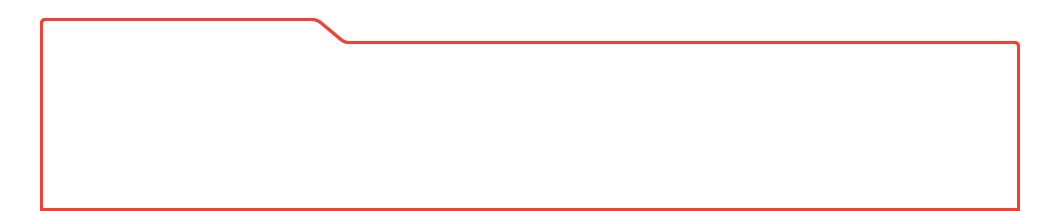
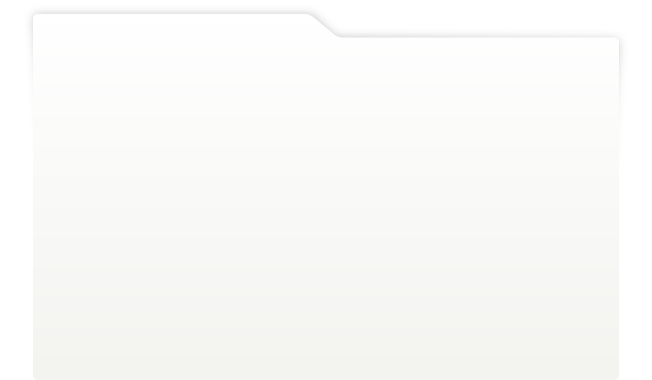
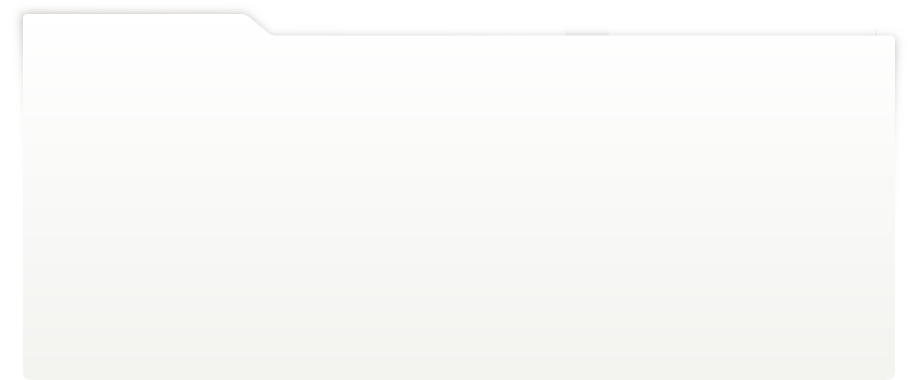
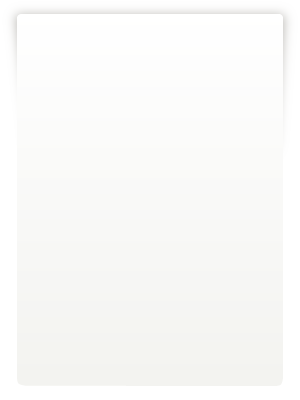
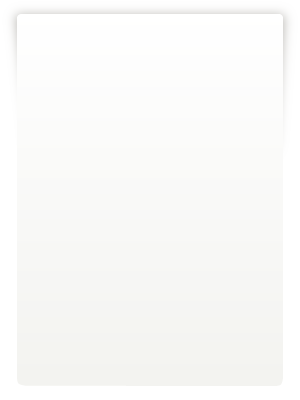
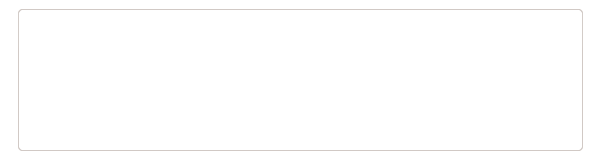
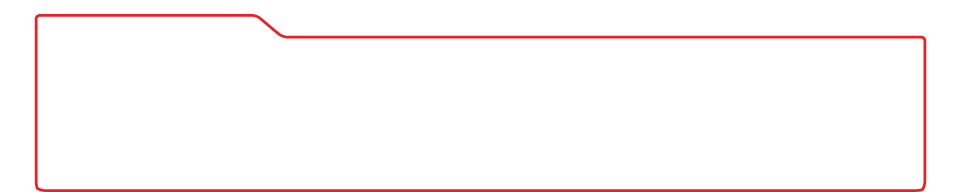
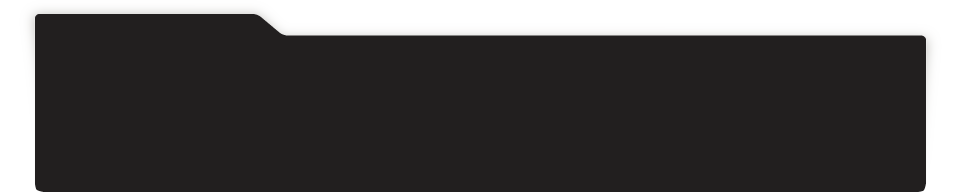
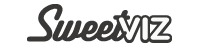
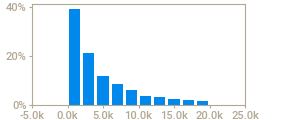
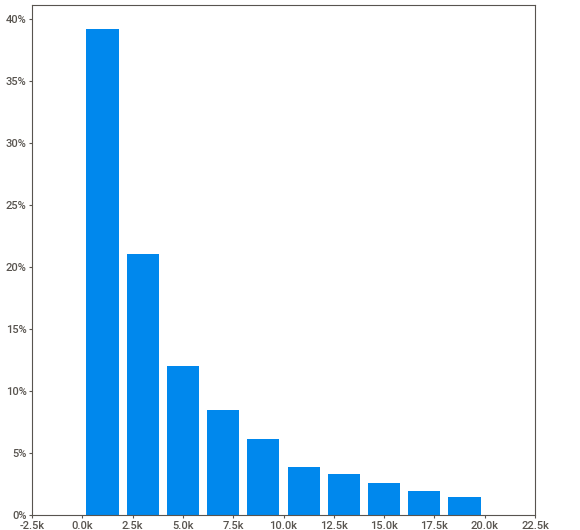
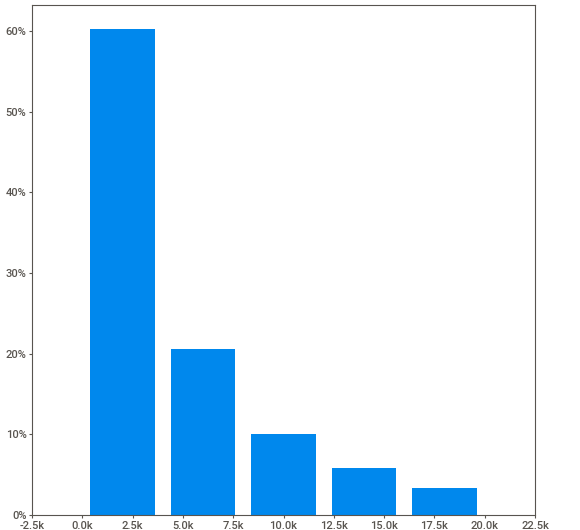
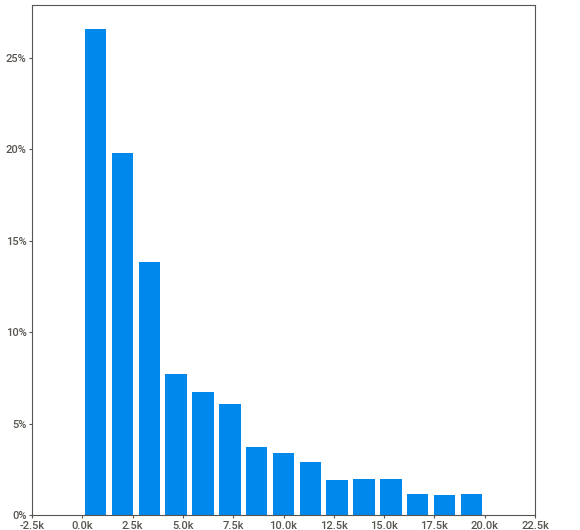
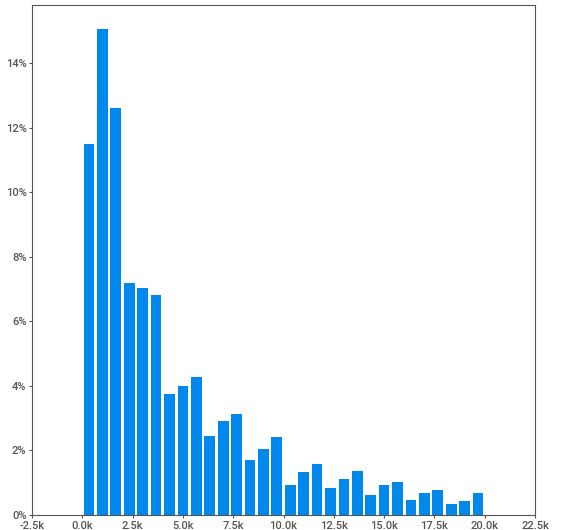
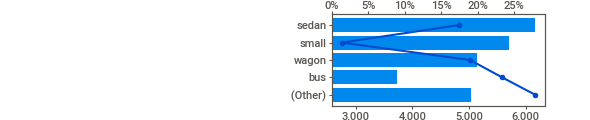
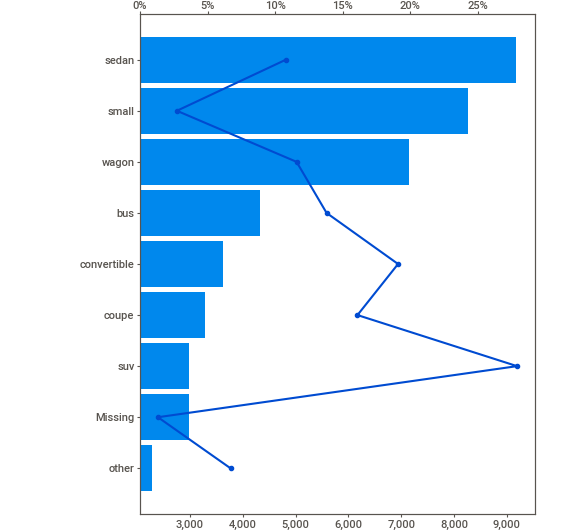
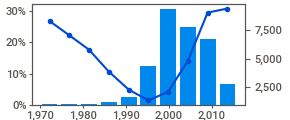
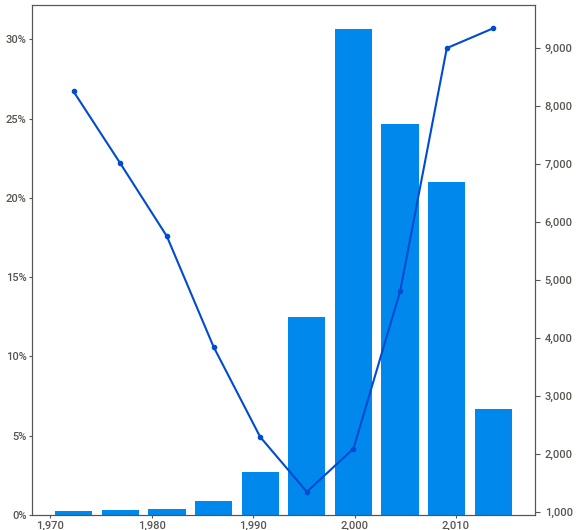
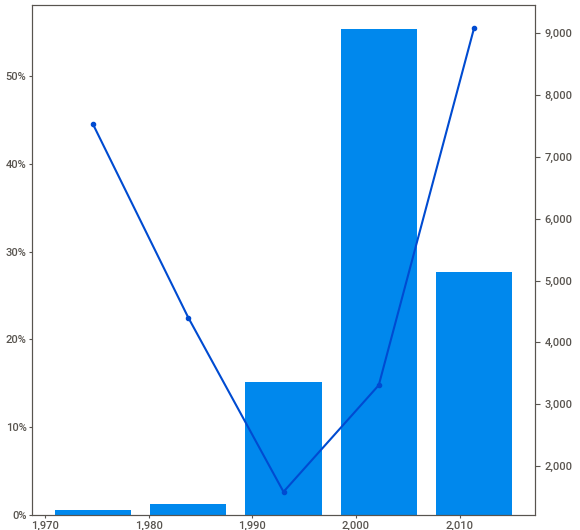
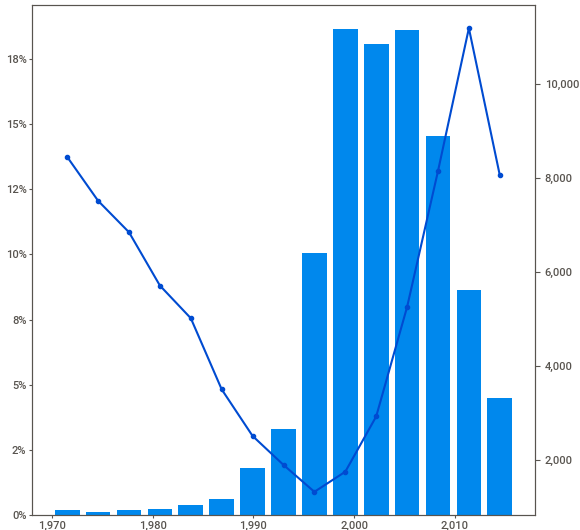
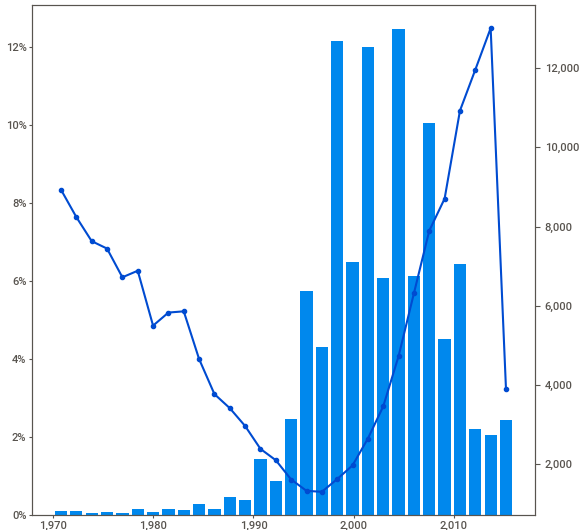
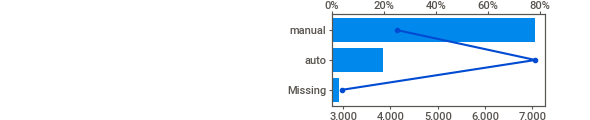
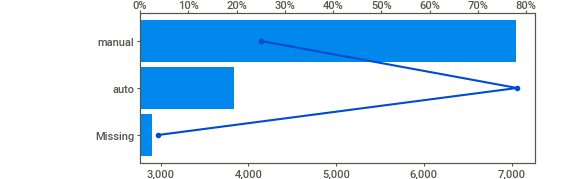
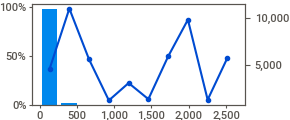
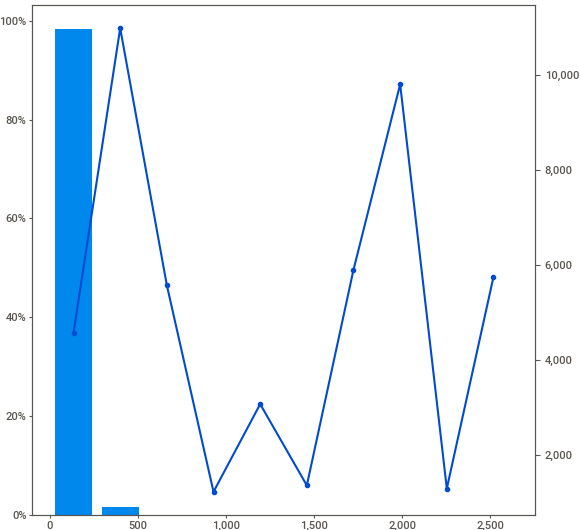
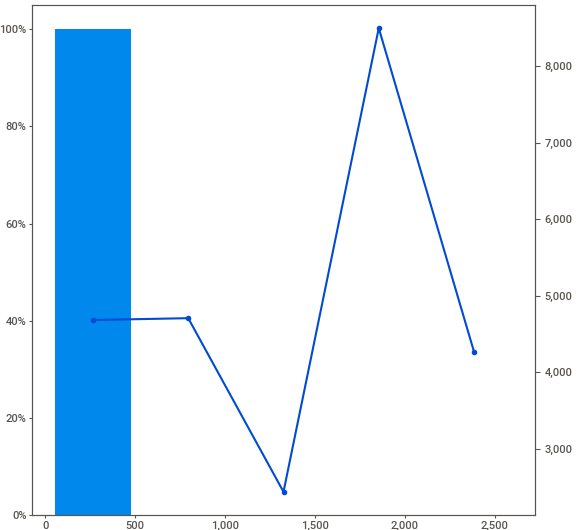
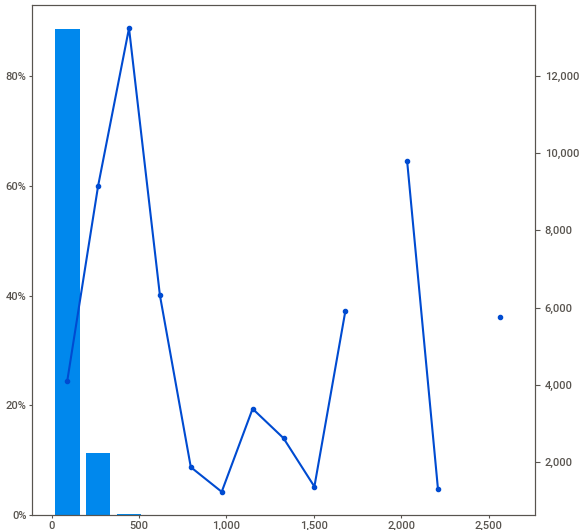
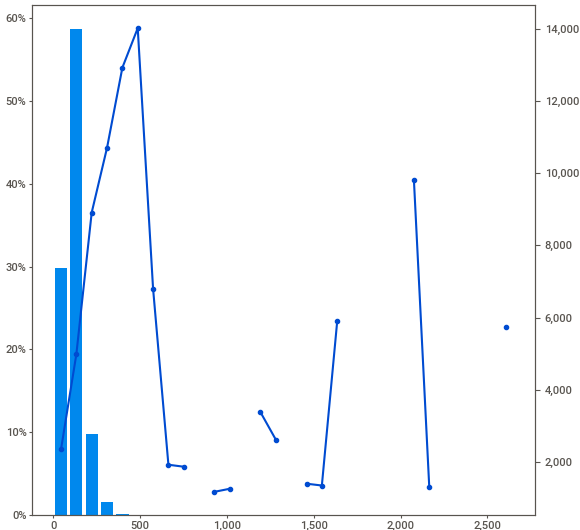
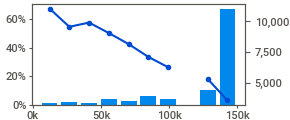
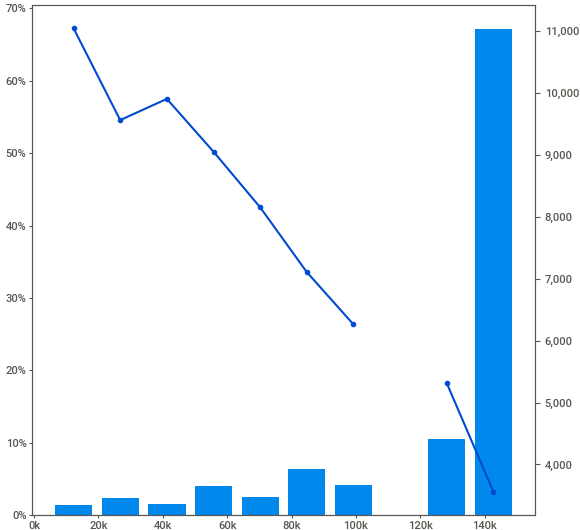
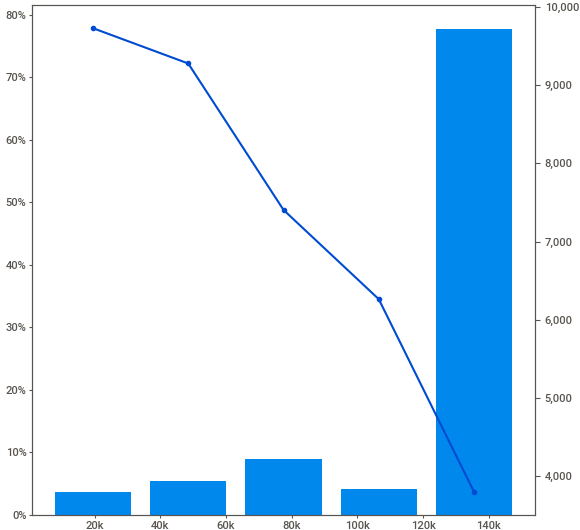
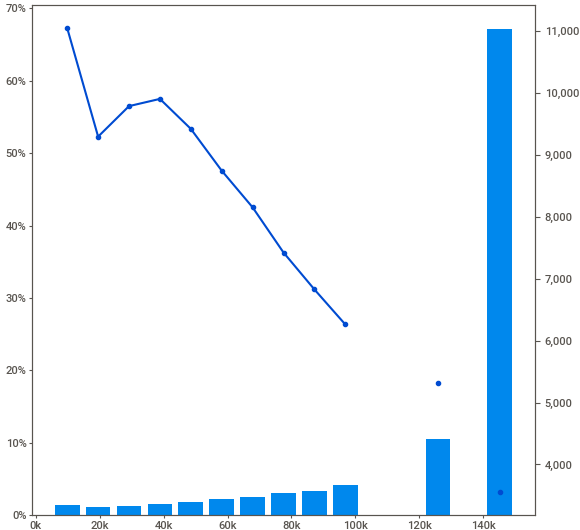
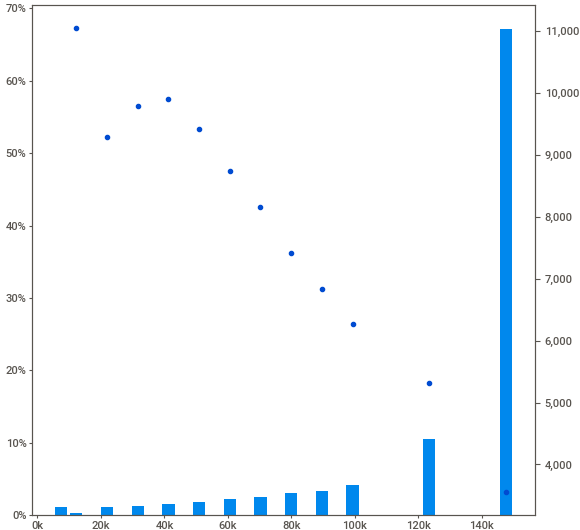
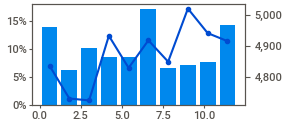
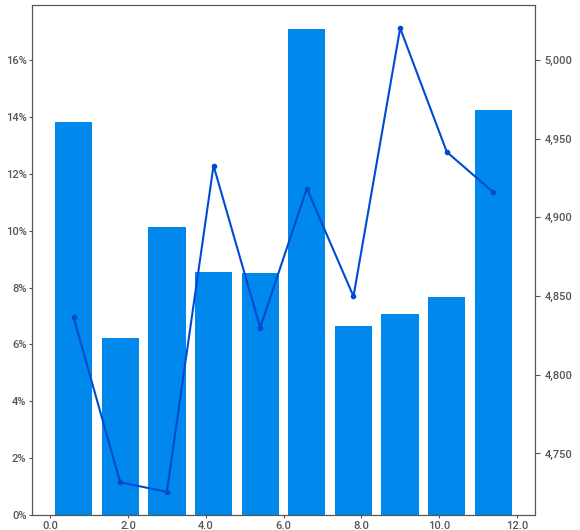
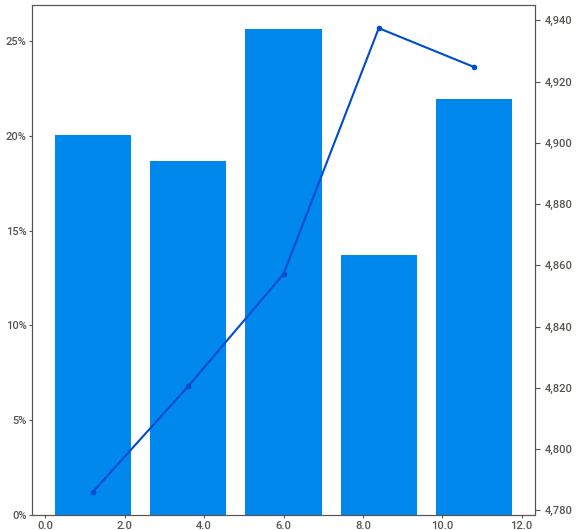
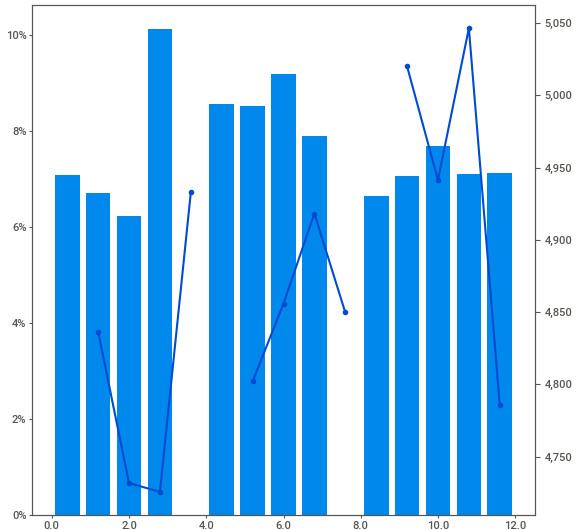
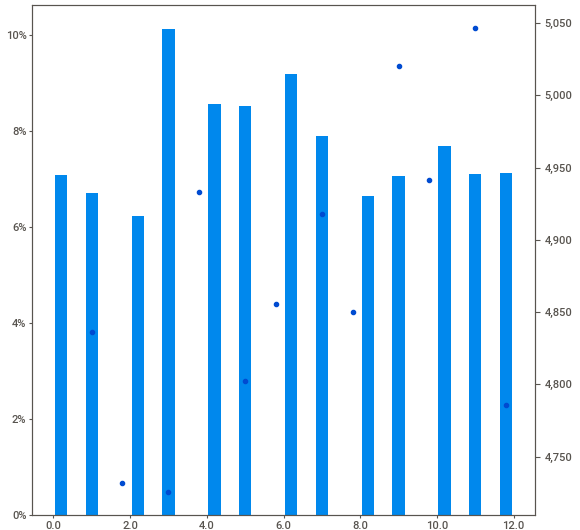
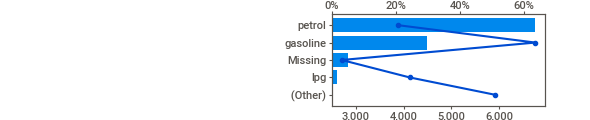
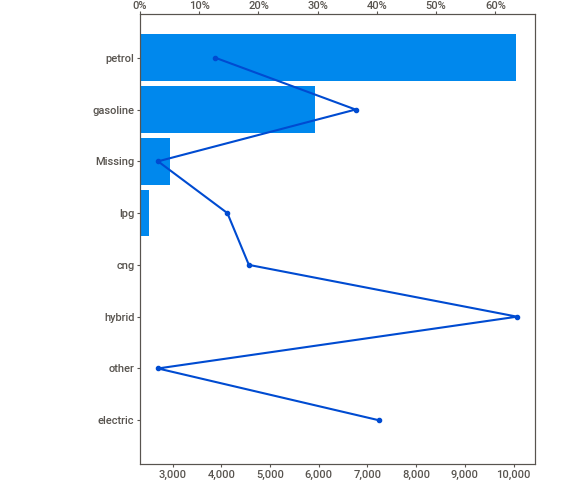
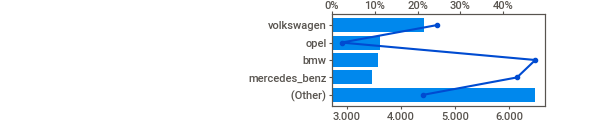
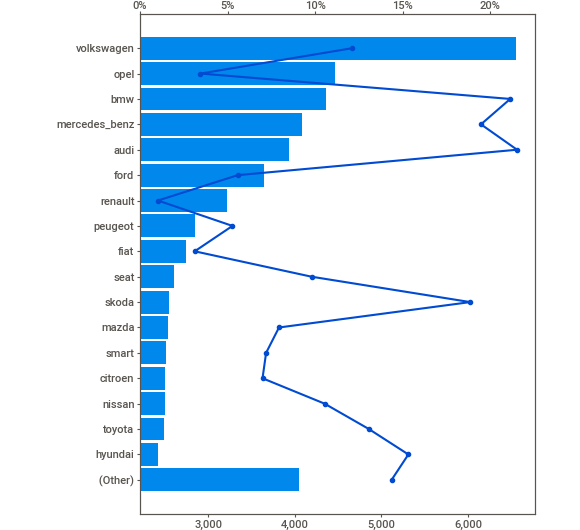
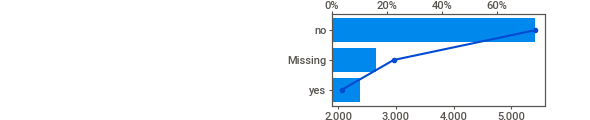
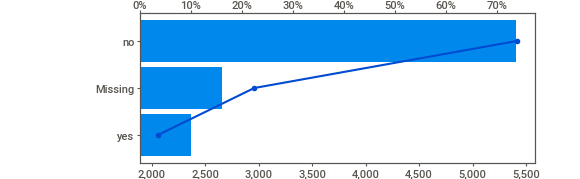
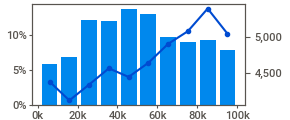
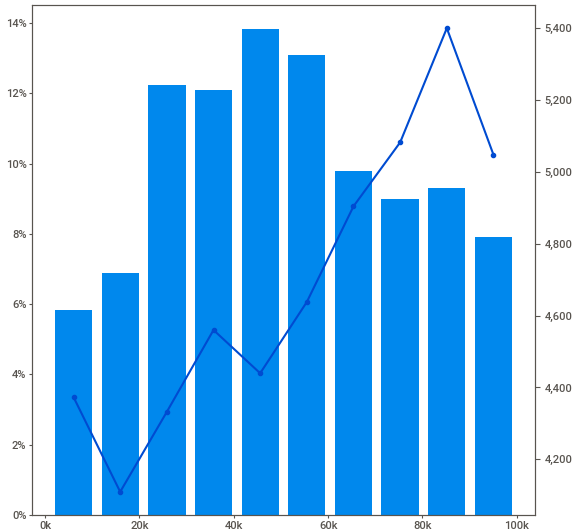
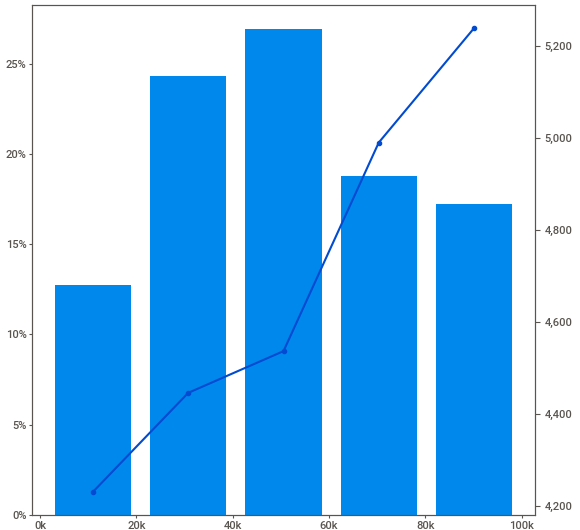
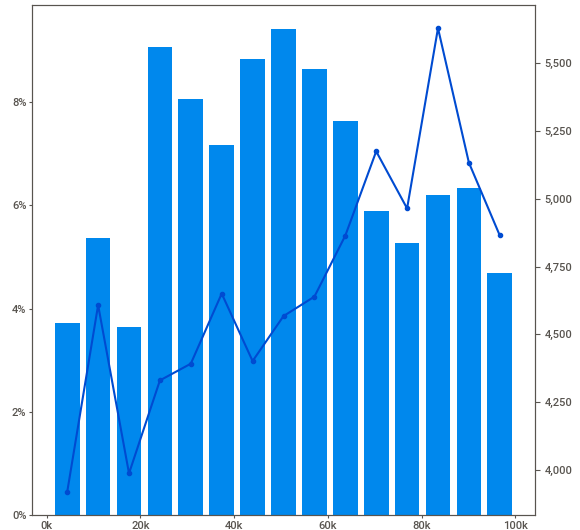
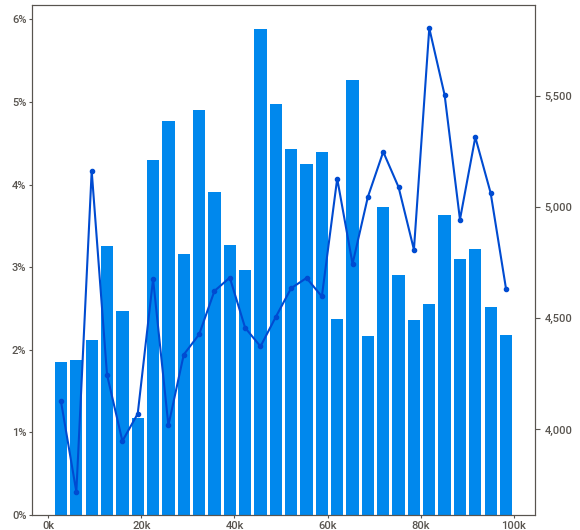
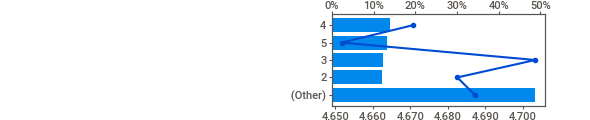
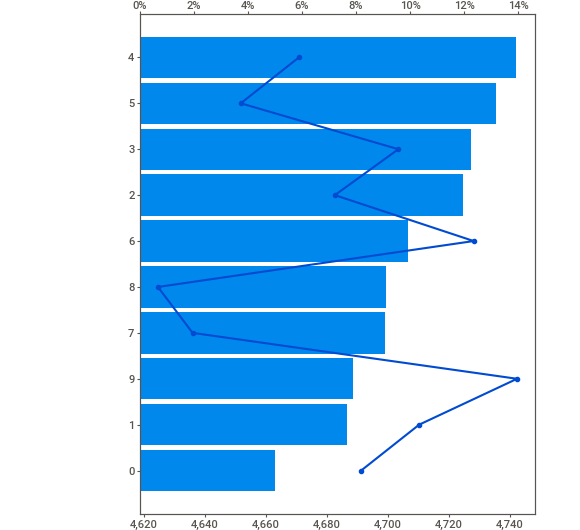
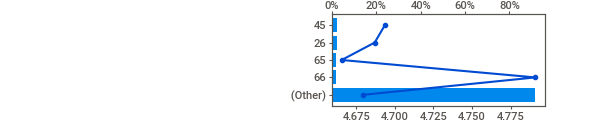
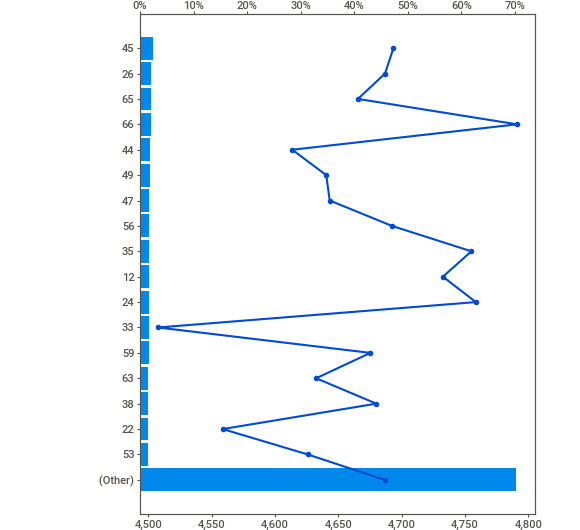
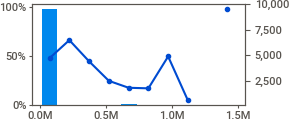
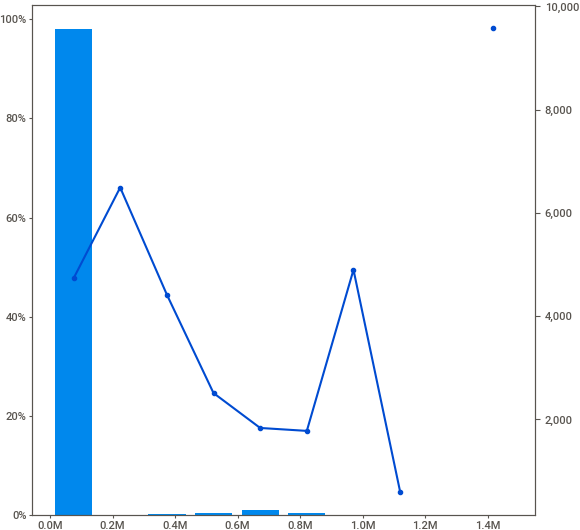
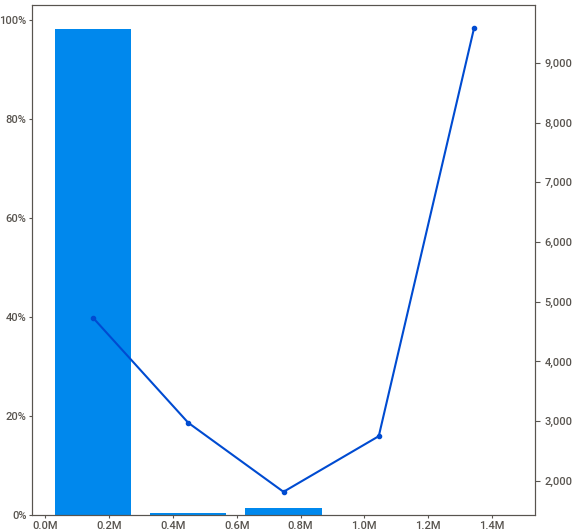
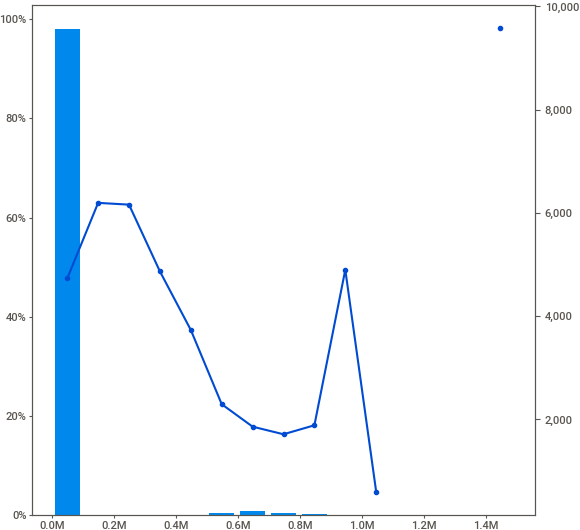
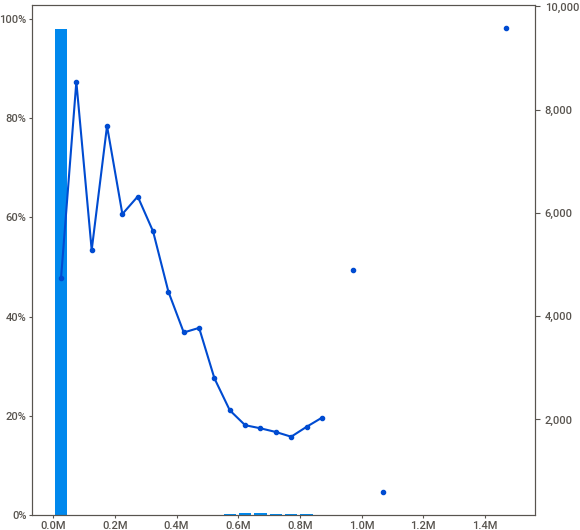
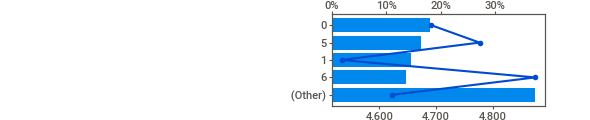
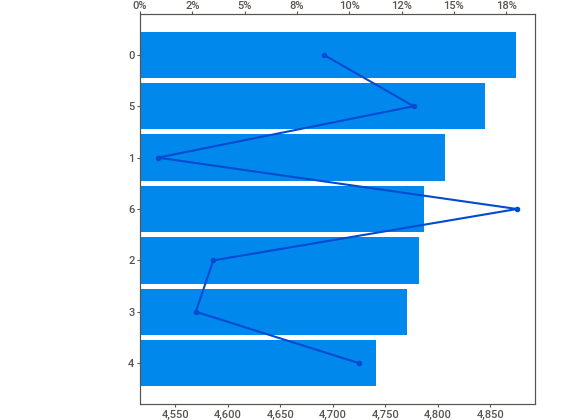
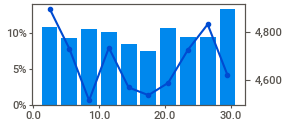
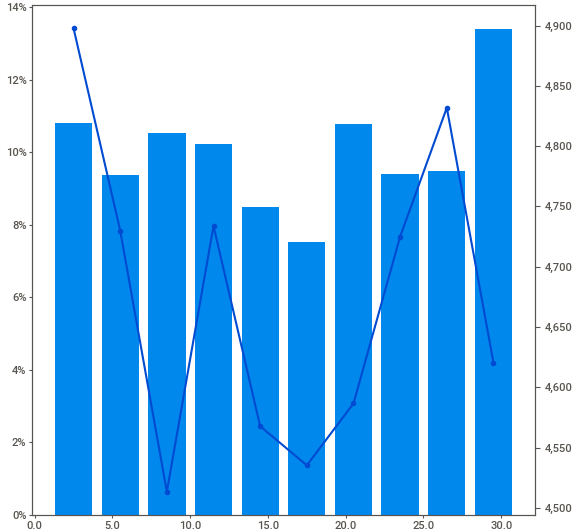
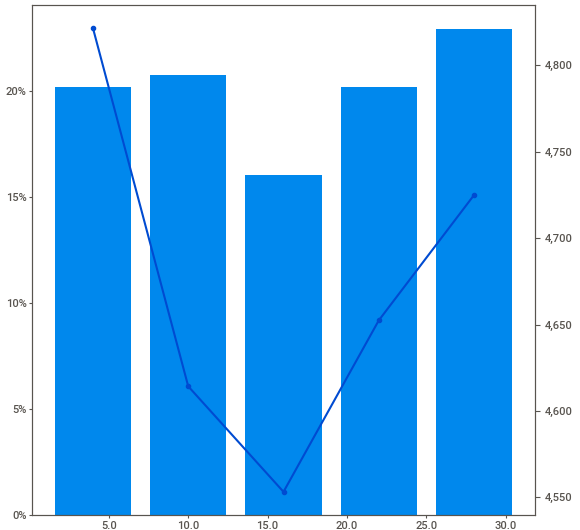
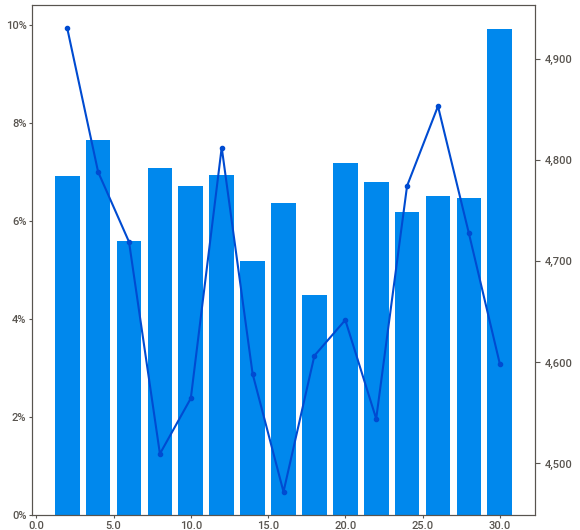
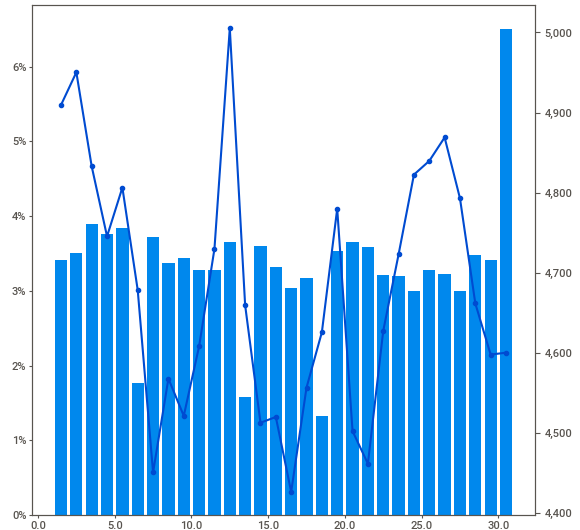
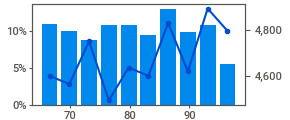
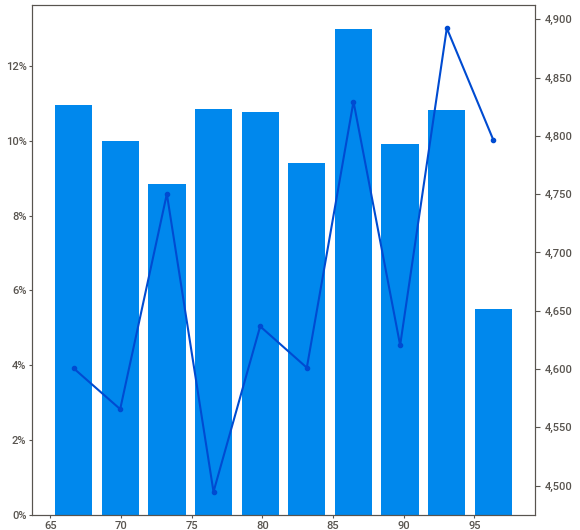
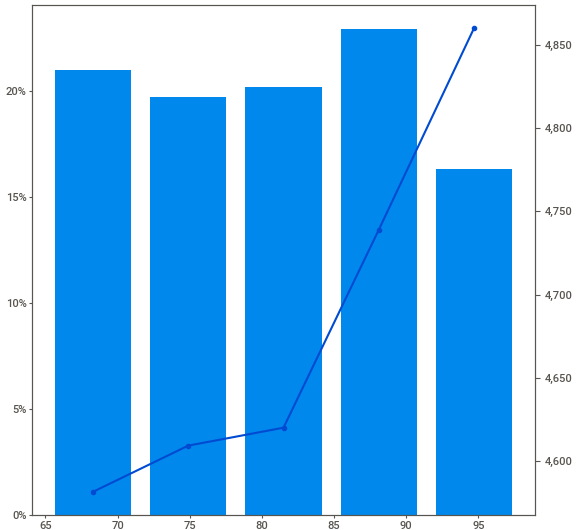
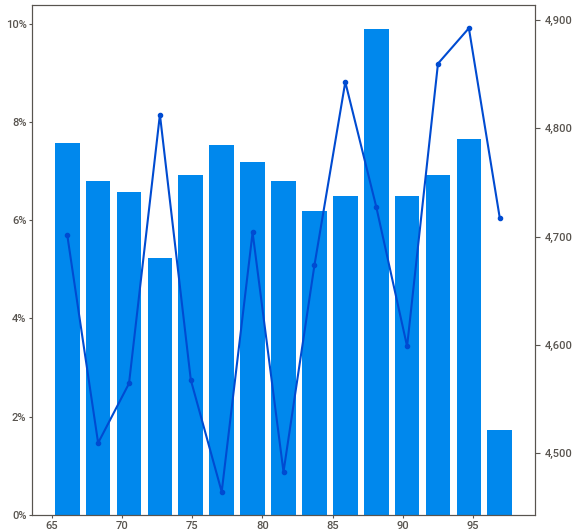
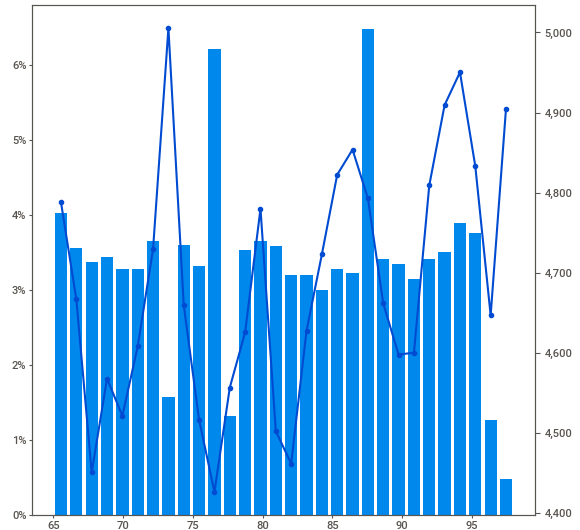
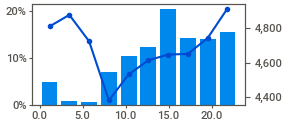
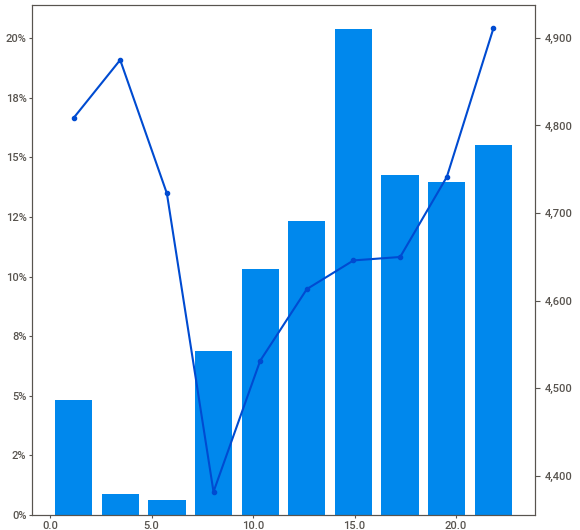
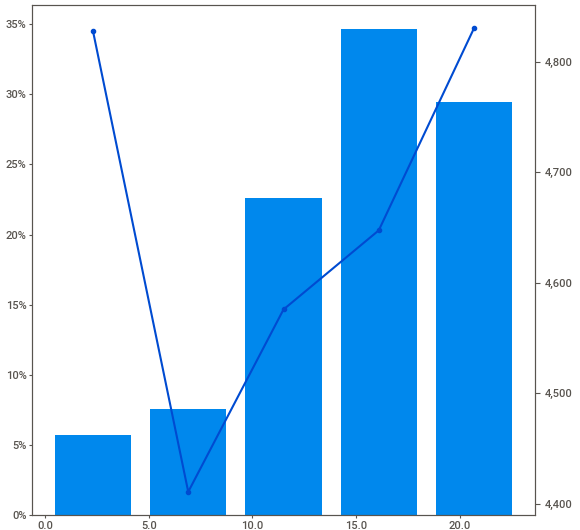
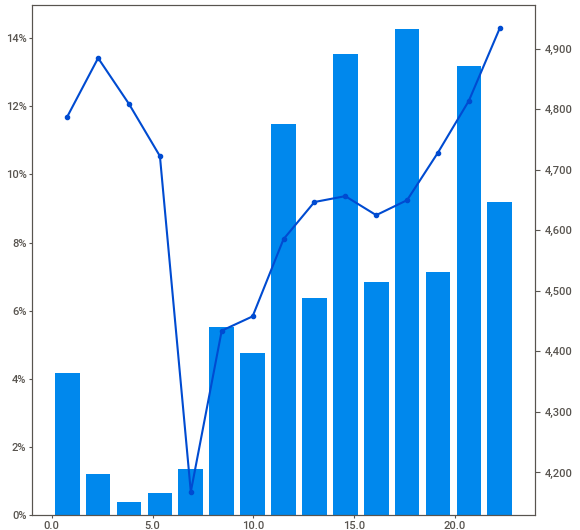
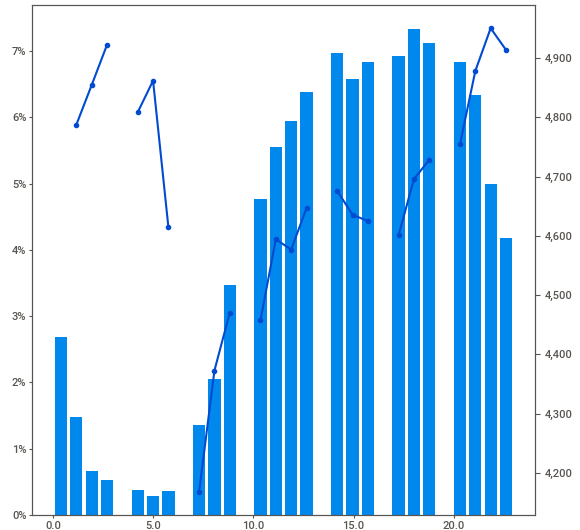
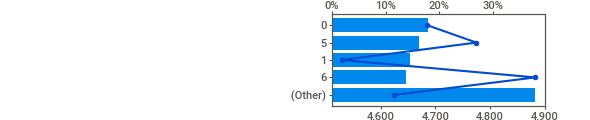
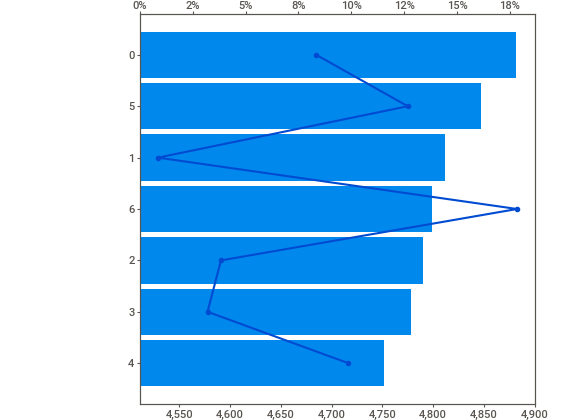
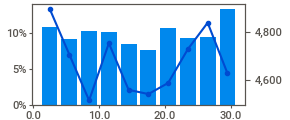
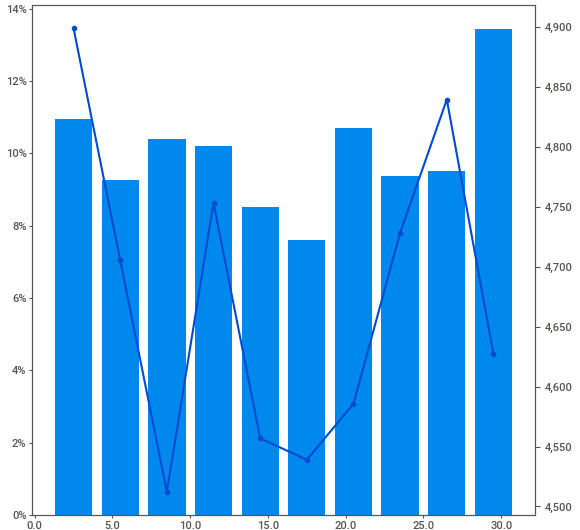
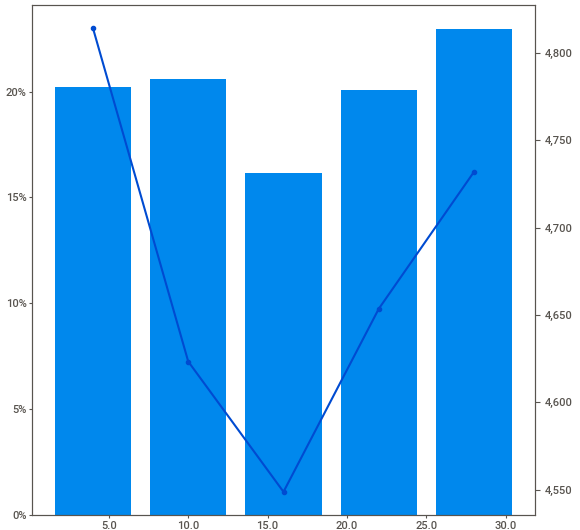
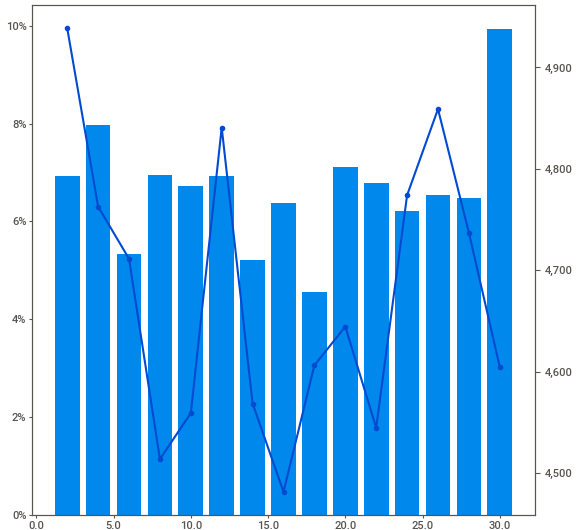
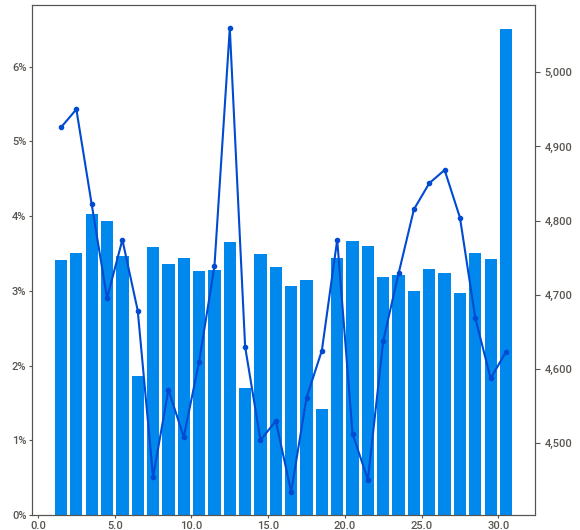
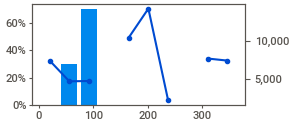
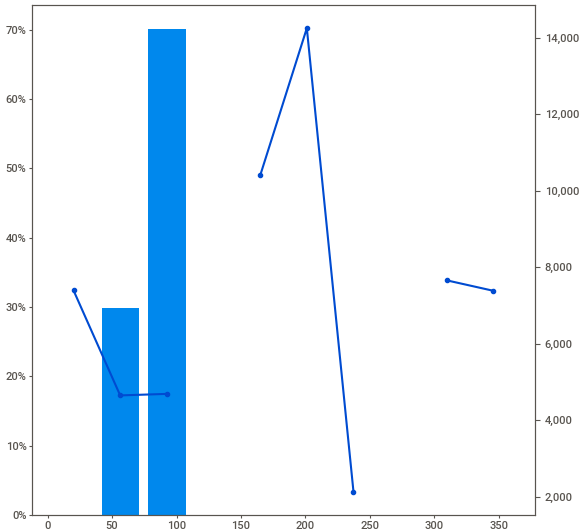
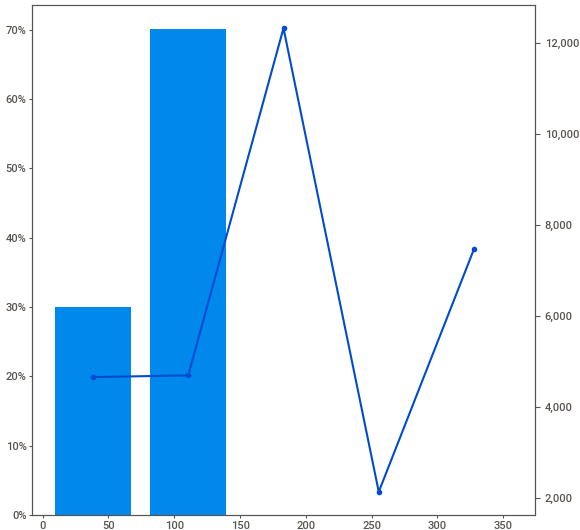
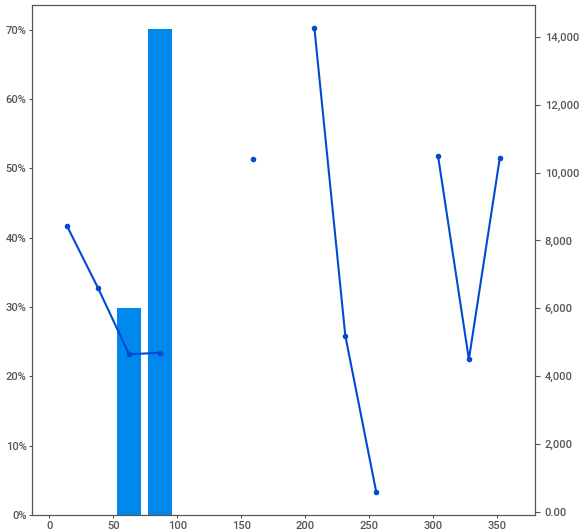
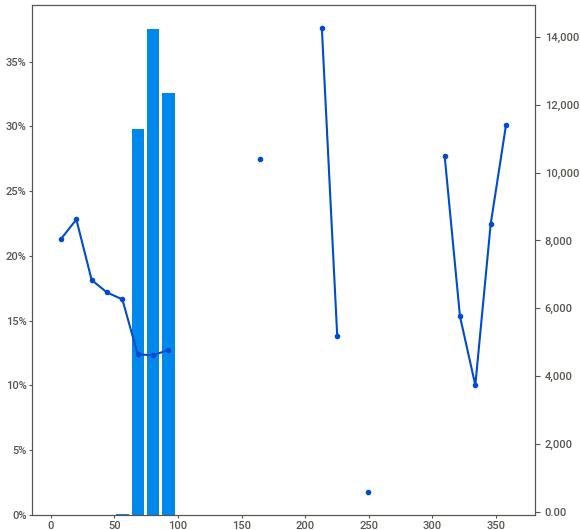
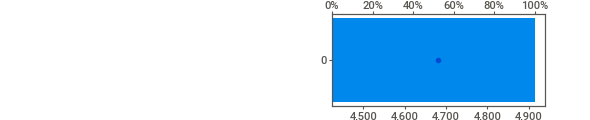
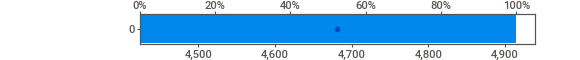
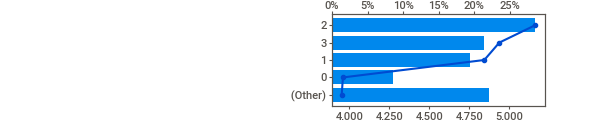
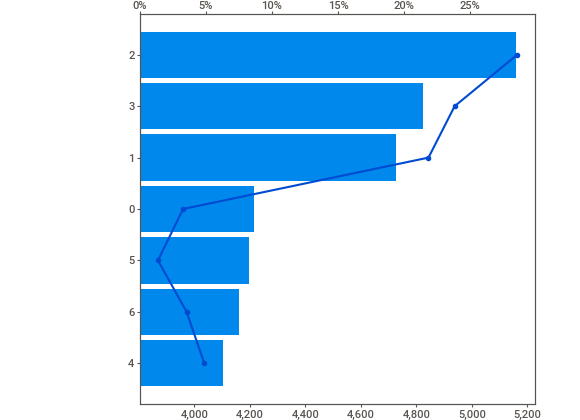
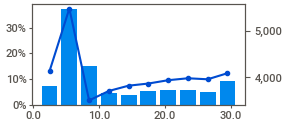
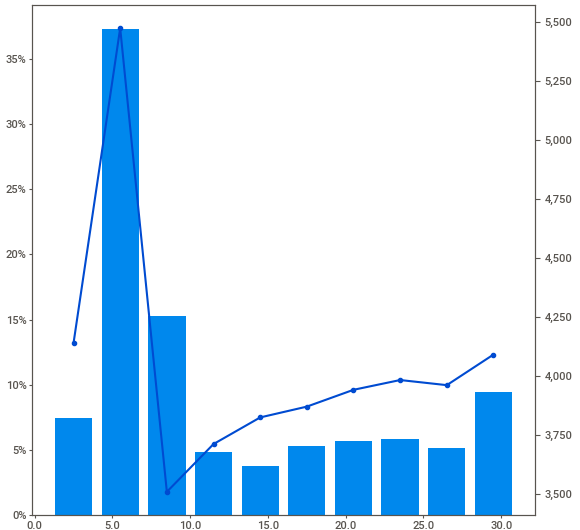
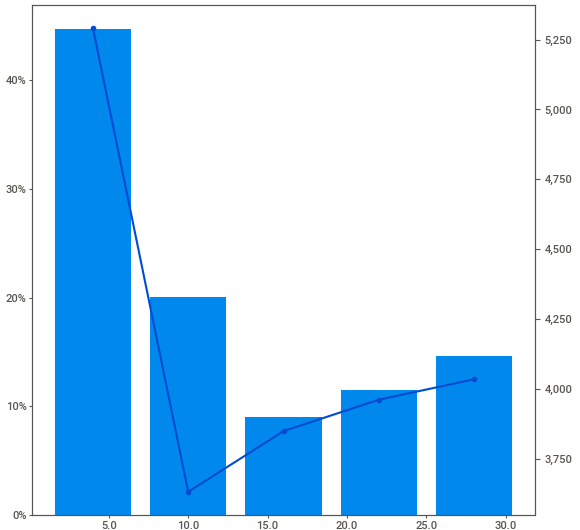
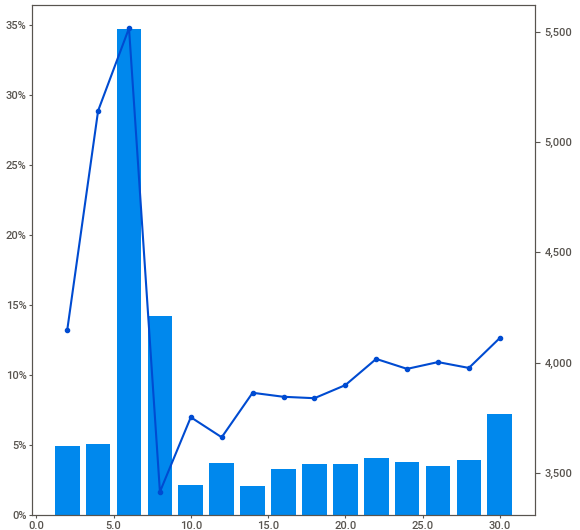
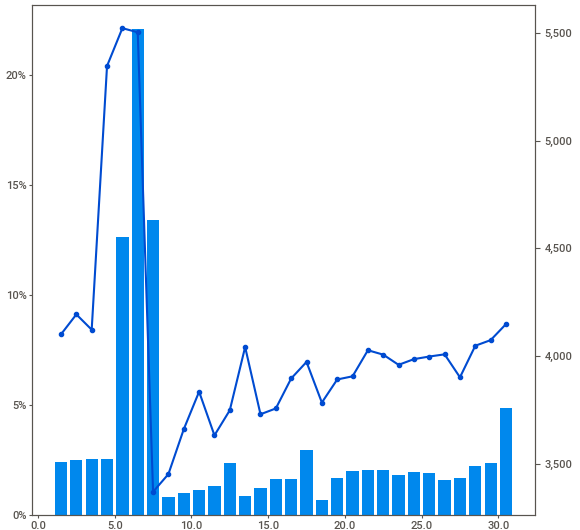
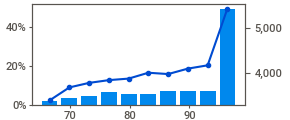
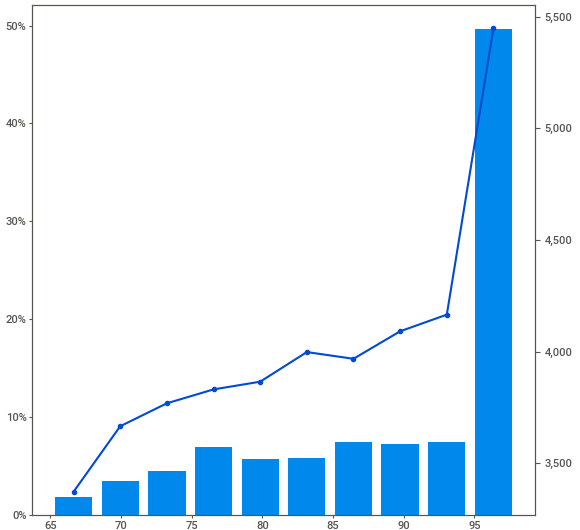
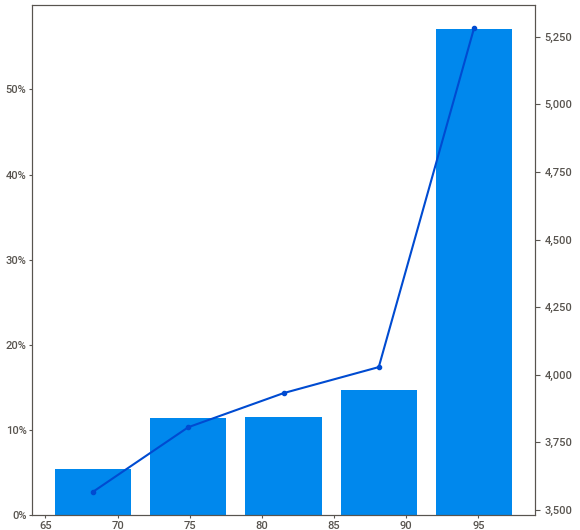
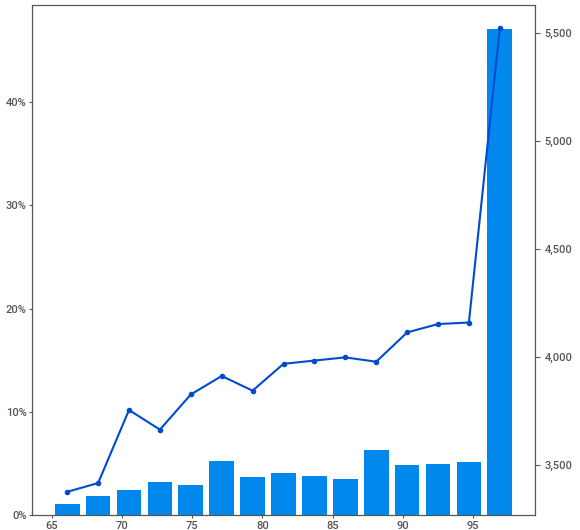
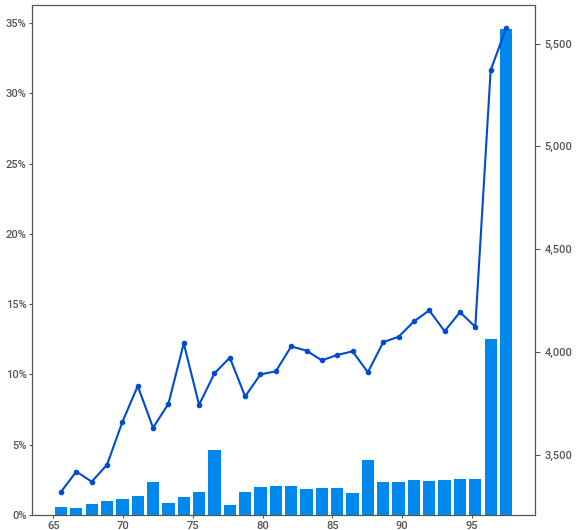
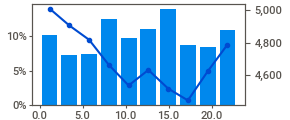
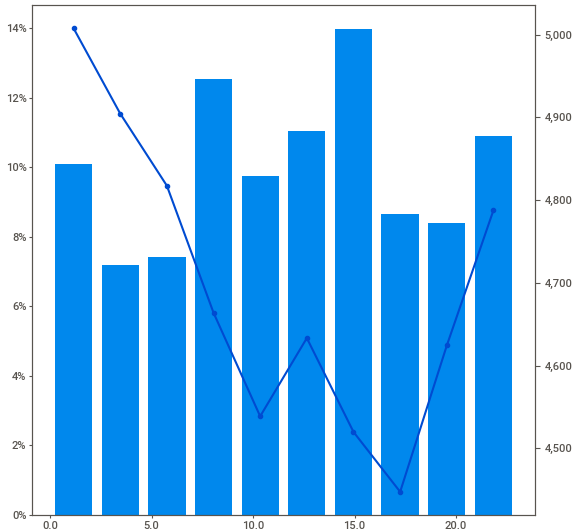
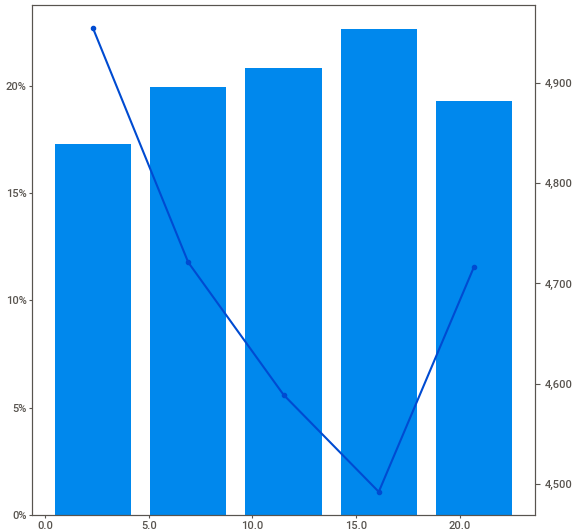
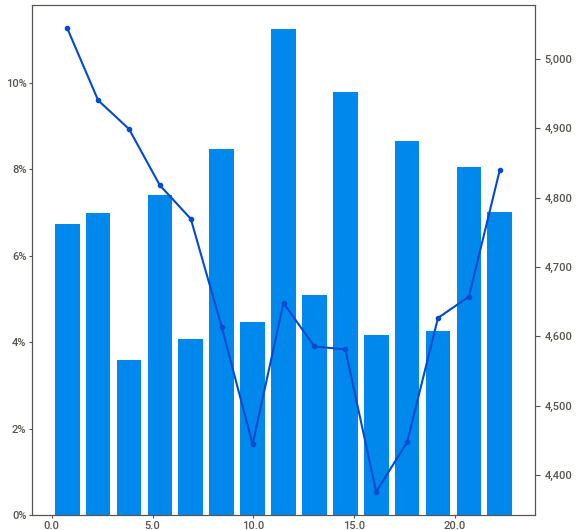
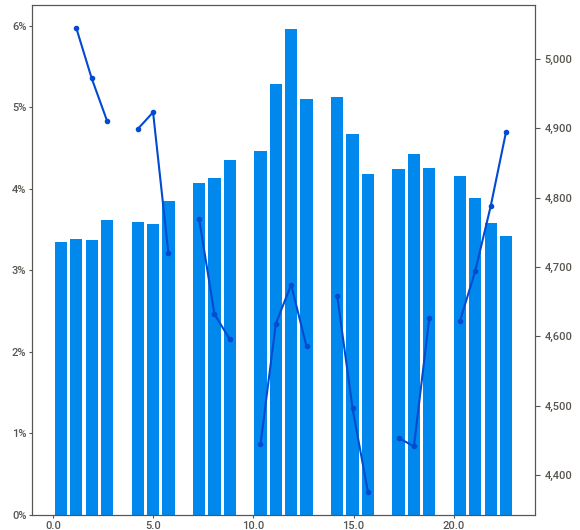
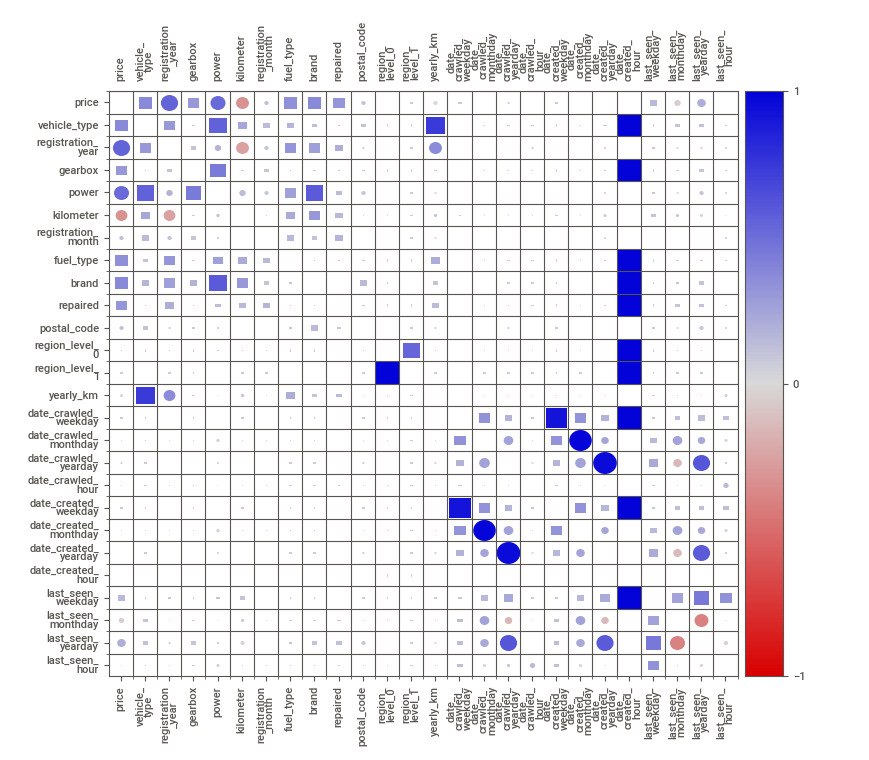
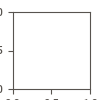

In [48]:
full_report = sweetviz.analyze(data_train_postprocessing, "price")
full_report.show_notebook()

Видим по кореляционной матрице, что после подготовки train-данных :
* усилилась корреляция цены c power, а также логично усилилась логичная связь power c vehicle_type
* усилилась корреляция цены c registration_year, а также усилилась логичная связь registration_year c kilometer
* из новых признаков проявляется корреляция с last_seen, а именно с ее дневными компонентами
* однозначной корреляции с регионами не видно - возможно, стоит попробовать разделить все эти регионы на восточную и западную Германию, например (TODO:)

## 1.5. Pipeline

### 1.5.1. Кастомные классы и функции

Класс для применения функции к датафрейму - будем использовать для добавления признаков:

In [49]:
class DataframeFunctionTransformer(TransformerMixin):
    def __init__(self, func, **kwargs):
        self.func = func
        self.args = kwargs

    def transform(self, input_df, **transform_params):
        return self.func(input_df, **self.args)

    def fit(self, X, y=None, **fit_params):
        return self

Функция для извлечения из date-признака частей даты:

In [50]:
def add_date_parts(dataframe, **kwargs):
    df = dataframe.copy()
    if kwargs["drop"] == None:
        drop = False
    else:
        drop = kwargs["drop"]

    if kwargs["fields"] == None:
        fields = ["date"]
    else:
        fields = kwargs["fields"]
    for field in fields:
        date = pd.to_datetime(df[field])
        df.loc[:, field + "_weekday"] = date.dt.weekday
        df.loc[:, field + "_monthday"] = date.dt.day
        df.loc[:, field + "_yearday"] = date.dt.dayofyear
        df.loc[:, field + "_hour"] = date.dt.hour
        if drop == True:
            df.drop(field, axis=1)
    return df

Функция для добавления годового пробега:

In [51]:
def add_yearly_km(dataframe, **kwargs):
    df = dataframe.copy()
    df["yearly_km"] = (
        df["kilometer"]
        / (
            df["date_created"] - pd.to_datetime(df["registration_year"], format="%Y")
        ).dt.days
        * 365
    ).astype(int)
    return df

Функция для добавления регионов по почтовому индексу:

In [52]:
def add_regions_from_postal_code(dataframe, **kwargs):
    df = dataframe.copy()
    if kwargs["levels"] == None:
        levels = 0
    else:
        levels = kwargs["levels"]
    for level in levels:
        df["region_level_" + str(level)] = (
            df["postal_code"]
            .astype("string")
            .apply(lambda str: str if len(str) == 5 else ("0" + str))
            .apply(lambda str: str[: level + 1])
            # .apply(lambda str: 10 + int(str[: level + 1]))
        )
    return df

Функция для добавления индикатора выбросов:

In [53]:
def add_zscore(
    arr,
    add_has_outliers=True,
    add_count_of_outliers=True,
    add_abs_mean_z_score=True,
    add_mean_z_score=True,
):
    if add_has_outliers:
        arr = np.column_stack(
            (
                arr,
                (abs(zscore(arr, nan_policy="omit")) > 3).sum(axis=1) > 0,
            )
        )
    if add_count_of_outliers:
        arr = np.column_stack(
            (
                arr,
                (abs(zscore(arr, nan_policy="omit")) > 3).sum(axis=1),
            )
        )
    if add_abs_mean_z_score:
        arr = np.column_stack(
            (
                arr,
                np.nanmean(abs(zscore(arr, nan_policy="omit")), axis=1),
            )
        )
    if add_mean_z_score:
        arr = np.column_stack(
            (
                arr,
                np.nanmean(zscore(arr, nan_policy="omit"), axis=1),
            )
        )
    return arr

Функция для добавления индикатора пропусков:

In [54]:
def add_nan_indicator(arr):
    return np.column_stack((arr, np.isnan(arr).sum(axis=1)))

Класс для восстановления значений по группам:

In [55]:
class GroupImputer(BaseEstimator, TransformerMixin):
    """
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.

    Parameters
    ----------
    group_cols : list
        List of columns used for calculating the aggregated value
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']
    Returns
    -------
    X : array-like
        The array with imputed values in the target column
    """

    def __init__(self, group_cols, target, metric="mean"):

        assert metric in [
            "mean",
            "median",
        ], "Unrecognized value for metric, should be mean/median"
        assert type(group_cols) == list, "group_cols should be a list of columns"
        assert type(target) == str, "target should be a string"

        self.group_cols = group_cols
        self.target = target
        self.metric = metric

    def fit(self, X, y=None):

        assert (
            pd.isnull(X[self.group_cols]).any(axis=None) == False
        ), "There are missing values in group_cols"

        impute_map = (
            X.groupby(self.group_cols)[self.target]
            .agg(self.metric)
            .reset_index(drop=False)
        )

        self.impute_map_ = impute_map

        return self

    def transform(self, X, y=None):

        # make sure that the imputer was fitted
        check_is_fitted(self, "impute_map_")

        X = X.copy()

        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind, self.target] = X.loc[ind, self.target].fillna(row[self.target])

        return X.values

In [56]:
class ModelSwitcher(BaseEstimator):
    def __init__(
        self,
        estimator=RandomForestRegressor(),
    ):
        """
        A Custom BaseEstimator that can switch between models.
        :param estimator: sklearn object - The model
        """

        self.estimator = estimator

    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    # @available_if(self.is_classifier(estimator))
    # def predict_proba(self, X):
    #     return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

In [57]:
class Debug(BaseEstimator, TransformerMixin):
    def transform(self, X):

        self.shape = X.shape

        print(self.shape)
        self.copy_of_X = X.copy()
        print(X[:10])  # TODO: check 10 is not less than len
        return X

    def fit(self, X, y=None, **fit_params):
        return self

### 1.5.2. Сборка пайплайна

Сделаем пайплайны для обработки признаков:
* feature_creation_pipe - извлечение новых признаков из существующих данных
* num_pipe - для обработки численных признаков
* cat_pipe - для обработки численных признаков
* transformer - для обработки числовых признаков, причем с помощью make_column_selector числовые определяются динамически (чтобы учесть сгенерированные в feature_creation_pipe признаки)

In [58]:
# date feature pipeline
feature_creation_pipe = Pipeline(
    [
        ("clip_reg_date", Winsorizer(tail="both", variables=["registration_year"])),
        # the above is needed to add yearly mileage
        (
            "add_date_parts",
            DataframeFunctionTransformer(
                add_date_parts, fields=["last_seen"], drop=True
            ),
        ),
        (
            "add_yearly_km",
            DataframeFunctionTransformer(add_yearly_km),
        ),
        (
            "add_regions",
            DataframeFunctionTransformer(add_regions_from_postal_code, levels=[0, 1]),
        ),
    ]
)

# categorial feature pipeline
cat_pipe = Pipeline(
    [
        ("const_imputer", CategoricalImputer(variables=(list(set(categorical)-set(["model"]))))),
        # categorial = ["vehicle_type", "gearbox", "model", "fuel_type","repaired"]
        (
            "encoder",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        ),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", None),
    ]
)

# numeric features pipeline
num_pipe = Pipeline(
    [
        # (
        #     "add_zscore",
        #     DataframeFunctionTransformer(add_zscore),
        # ),
        # ("dbg_num1", Debug()),
        ("clip_outliers", Winsorizer(tail="both", variables=["power"])),
        # ("dbg_num2", Debug()),
        ("num_imputer", SimpleImputer(strategy="mean")),
        # (
        #     "zero_imputer",
        #     KNNImputer(n_neighbors=5, weights="uniform", missing_values=0),
        # ),
        # ("dbg_num3", Debug()),
        ("scaler", None),
        # ("dbg_num4", Debug()),
    ]
)


# applying num_pipe to dynamically selecting numeric types
transformer = ColumnTransformer(
    transformers=[
        ("num", num_pipe, make_column_selector(dtype_include=np.number)),
        ("cat", cat_pipe, make_column_selector(dtype_include=object)),
    ],
    remainder="drop",
    n_jobs=-1,
)

In [59]:
pipeline = Pipeline(
    [
        ("feature_creation_pipe", feature_creation_pipe),
        # ("dbg0", Debug()),
        # (
        #     "add_regions",
        #     DataframeFunctionTransformer(add_regions_from_postal_code, levels=[0, 1]),
        # ),
        ("drop", DropFeatures(["date_crawled", "date_created"])),
        ("transformer", transformer),
        # ("dbg3", Debug()),
        ("model", ModelSwitcher()),
    ]
)

In [60]:
pipeline.get_params()

{'memory': None,
 'steps': [('feature_creation_pipe',
   Pipeline(steps=[('clip_reg_date',
                    Winsorizer(tail='both', variables=['registration_year'])),
                   ('add_date_parts',
                    <__main__.DataframeFunctionTransformer object at 0x7f2ffcbd9c10>),
                   ('add_yearly_km',
                    <__main__.DataframeFunctionTransformer object at 0x7f2ffcbd9190>),
                   ('add_regions',
                    <__main__.DataframeFunctionTransformer object at 0x7f2ffcbd9430>)])),
  ('drop', DropFeatures(features_to_drop=['date_crawled', 'date_created'])),
  ('transformer',
   ColumnTransformer(n_jobs=-1,
                     transformers=[('num',
                                    Pipeline(steps=[('clip_outliers',
                                                     Winsorizer(tail='both',
                                                                variables=['power'])),
                                                    

## 1.6. Обучение моделей

Для оценки качества в GridSearch будем использовать RMSE:

In [61]:
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

Предварительно перемешаем данные, так как GridSearch этого не делает:

In [62]:
data_train = data_train.sample(frac=1, random_state=19_12_22).reset_index(drop=True)

In [63]:
X = data_train.drop("price", axis=1)
y = data_train["price"]

### 1.6.1. Проверка модели на адекватность

In [64]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X, y)

DummyRegressor()

In [65]:
mean_squared_error(
    data_test["price"],
    dummy_regr.predict(data_test.drop("price", axis=1)),
    squared=False,
)

4511.085460747523

### 1.6.2. LGBMRegressor

Перебираемые гиперпараметры и модели:

In [66]:
parameters = [
    {
        "model__estimator": [
            LGBMRegressor(random_state=19_12_22)
            # learning_rate=0.17, n_estimators=300,
        ],
        "model__estimator__n_estimators": list(range(400, 601, 20)),
        "model__estimator__learning_rate": [x / 1000.0 for x in range(160, 180, 5)],
        "drop__features_to_drop": [
            [
                "date_crawled",
                "date_created",
                "postal_code",
                "last_seen_hour",
                "registration_year",
                "registration_month",
                "last_seen",
                
            ],
                   
        ],
#         'feature_creation_pipe__add_regions':[None],
#         'feature_creation_pipe__add_yearly_km':[None],
#         'feature_creation_pipe__add_date_parts':[None],
    },
]

Будем использовать перебор параметров с помощью RandomizedSearchCV c ограниченным числом итераций (n_iter):

In [67]:
rand_search_cv_lgbm = RandomizedSearchCV(
    pipeline,
    parameters,
    n_iter=3,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=19_12_22,
)

Обучаем:

In [68]:
%%time
rand_search_cv_lgbm.fit(X, y)
print()


CPU times: user 1min 27s, sys: 1.33 s, total: 1min 29s
Wall time: 29.8 s


Смотрим на лучшую модель:

In [69]:
rand_search_cv_lgbm.best_estimator_

Pipeline(steps=[('feature_creation_pipe',
                 Pipeline(steps=[('clip_reg_date',
                                  Winsorizer(tail='both',
                                             variables=['registration_year'])),
                                 ('add_date_parts',
                                  <__main__.DataframeFunctionTransformer object at 0x7f2ffbbbba90>),
                                 ('add_yearly_km',
                                  <__main__.DataframeFunctionTransformer object at 0x7f2ffbbbbd30>),
                                 ('add_regions',
                                  <__main__.DataframeFunctionTransformer objec...
                                                                                                 'fuel_type'])),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   None)]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2ffbbbbeb0>)])),
                ('model',
                 ModelSwitcher(estimator=LGBMRegressor(learning_rate=0.16,
                                                       n_estimators=600,
                                                       random_state=191222)))])

RMSE лучшей модели умноженное на -1 (для минимизации):

In [70]:
rand_search_cv_lgbm.best_score_

-1541.524693479563

### 1.6.3. DecisionTreeRegressor

In [71]:
parameters_dtr = [
    {
        "model__estimator": [DecisionTreeRegressor(random_state=19_12_22)],
        "model__estimator__max_depth": list(range(5, 12)),
        # do not use absolute_error below - hangs up
        "model__estimator__criterion": [
            "squared_error",
            "friedman_mse",
            "poisson",
        ],
        "drop__features_to_drop": [
            [
                "date_crawled",
                "date_created",
                "postal_code",
                #"last_seen_hour",
                "registration_year",
                "registration_month",
                "last_seen"
                
            ],
                   
        ],
#         'feature_creation_pipe__add_regions':[None],
#         'feature_creation_pipe__add_yearly_km':[None],
#         'feature_creation_pipe__add_date_parts':[None],
    }
]

In [72]:
rand_search_cv_dtr = RandomizedSearchCV(
    pipeline,
    parameters_dtr,
    n_iter=3,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=19_12_22,
)

In [73]:
%%time
rand_search_cv_dtr.fit(X, y)
print()


CPU times: user 2.45 s, sys: 222 ms, total: 2.67 s
Wall time: 7.81 s


In [74]:
rand_search_cv_dtr.best_estimator_

Pipeline(steps=[('feature_creation_pipe',
                 Pipeline(steps=[('clip_reg_date',
                                  Winsorizer(tail='both',
                                             variables=['registration_year'])),
                                 ('add_date_parts',
                                  <__main__.DataframeFunctionTransformer object at 0x7f2ffbb86580>),
                                 ('add_yearly_km',
                                  <__main__.DataframeFunctionTransformer object at 0x7f2ffbb869a0>),
                                 ('add_regions',
                                  <__main__.DataframeFunctionTransformer objec...
                                                                                                 'vehicle_type',
                                                                                                 'fuel_type'])),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   None)]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2ffcb0a5e0>)])),
                ('model',
                 ModelSwitcher(estimator=DecisionTreeRegressor(max_depth=11,
                                                               random_state=191222)))])

In [75]:
rand_search_cv_dtr.best_score_

-1999.4364120213406

### 1.6.4. LinearRegression

In [76]:
parameters_linear = [
    {
        "model__estimator": [LinearRegression(n_jobs=-1)],
        "transformer__cat__encoder": [
            OneHotEncoder(
                drop="first",
                handle_unknown="infrequent_if_exist",
                min_frequency=0.01,
                max_categories=30,
            )
        ],
        "transformer__cat__scaler": [
            StandardScaler(with_mean=False),
            PowerTransformer(standardize=False),
        ],
        "transformer__num__scaler": [
            StandardScaler(),
            PowerTransformer(),
        ],
        "drop__features_to_drop": [
            [
                "date_crawled",
                "date_created",
                "postal_code",
                "last_seen_hour",
            ]
        ],
        "transformer__cat__encoder__max_categories": list(range(35, 61, 5)),
    }
]

In [77]:
rand_search_cv_lin = RandomizedSearchCV(
    pipeline,
    parameters_linear,
    n_iter=5,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=19_12_22,
)

In [78]:
%%time
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rand_search_cv_lin.fit(X, y)

/home/kaptoh/anaconda3/envs/practicum/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kaptoh/anaconda3/envs/practicum/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kaptoh/anaconda3/envs/practicum/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kaptoh/anaconda3/envs/practicum/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kaptoh/anaconda3/envs/practicum/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/kaptoh/anaconda3/envs/practicum/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: overflow encountered

CPU times: user 6.91 s, sys: 11.1 s, total: 18 s
Wall time: 19.7 s


In [79]:
rand_search_cv_lin.best_score_

-2534.5955528928644

In [80]:
rand_search_cv_lin.best_estimator_

Pipeline(steps=[('feature_creation_pipe',
                 Pipeline(steps=[('clip_reg_date',
                                  Winsorizer(tail='both',
                                             variables=['registration_year'])),
                                 ('add_date_parts',
                                  <__main__.DataframeFunctionTransformer object at 0x7f2ffb83c220>),
                                 ('add_yearly_km',
                                  <__main__.DataframeFunctionTransformer object at 0x7f2ffb83c2e0>),
                                 ('add_regions',
                                  <__main__.DataframeFunctionTransformer objec...
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='infrequent_if_exist',
                                                                                 max_categories=55,
                                                                                 min_frequency=0.01)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2ffb792df0>)])),
                ('model',
                 ModelSwitcher(estimator=LinearRegression(n_jobs=-1)))])

### 1.6.5. RandomForestRegressor

In [81]:
parameters_rfr = [
    {
        "model__estimator": [RandomForestRegressor(n_jobs=-1, random_state=19_12_22)],
        "model__estimator__n_estimators": list(range(30, 51, 1)),
        "model__estimator__max_depth": list(range(2, 15)),
        "drop__features_to_drop": [
            [
                "date_crawled",
                "date_created",
                "postal_code",
                "last_seen_hour",
                "registration_year",
                "registration_month",
                "last_seen",
                
            ],
                   
        ],
#         'feature_creation_pipe__add_regions':[None],
#         'feature_creation_pipe__add_yearly_km':[None],
#         'feature_creation_pipe__add_date_parts':[None],
    },
]

In [82]:
rand_search_cv_rfr = RandomizedSearchCV(
    pipeline,
    parameters_rfr,
    n_iter=3,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    random_state=19_12_22,
)

In [83]:
%%time
rand_search_cv_rfr.fit(X, y)
print()


CPU times: user 1min 22s, sys: 752 ms, total: 1min 22s
Wall time: 47.5 s


In [84]:
rand_search_cv_rfr.best_estimator_

Pipeline(steps=[('feature_creation_pipe',
                 Pipeline(steps=[('clip_reg_date',
                                  Winsorizer(tail='both',
                                             variables=['registration_year'])),
                                 ('add_date_parts',
                                  <__main__.DataframeFunctionTransformer object at 0x7f2ffb82adc0>),
                                 ('add_yearly_km',
                                  <__main__.DataframeFunctionTransformer object at 0x7f2ffb82adf0>),
                                 ('add_regions',
                                  <__main__.DataframeFunctionTransformer objec...
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   None)]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f2ffb826c70>)])),
                ('model',
                 ModelSwitcher(estimator=RandomForestRegressor(max_depth=14,
                                                               n_estimators=49,
                                                               n_jobs=-1,
                                                               random_state=191222)))])

In [85]:
rand_search_cv_rfr.best_score_

-1684.8052038380004

## 1.7. Анализ моделей

Извлечем  из результатов по кросс валидации наших GridSearch-ей (для лучших моделей) данные по:
* качеству моделей mean_test_score / std_test_score - используется RMSE
* времени обучения mean_fit_time / std_fit_time
* времени предсказания mean_score_time / std_score_time

In [86]:
# aux function to write different data as collection to array to be converted to DataFrame;
def add_model_record(results_array, **kwargs):
    results_array.append(kwargs)

In [87]:
def extract_result_from_gridsearch_cv(rcv_result, model_name, model_results_array):
    cv_results = rcv_result.cv_results_
    best_index = np.where(cv_results["rank_test_score"] == 1)[0][0]
    add_model_record(
        model_results_array,
        model_name=model_name,
        model=rcv_result.best_estimator_,
        mean_test_score=abs(cv_results["mean_test_score"][best_index]),
        std_test_score=cv_results["std_test_score"][best_index],
        mean_fit_time=cv_results["mean_fit_time"][best_index],
        std_fit_time=cv_results["std_fit_time"][best_index],
        mean_score_time=cv_results["mean_score_time"][best_index],
        std_score_time=cv_results["std_score_time"][best_index],
        params=cv_results["params"][best_index],
    )


models_results = []
for rcv_result, model_name in zip(
    [
        rand_search_cv_lgbm,
        rand_search_cv_lin,
        rand_search_cv_dtr,
        rand_search_cv_rfr,
    ],
    [
        "LGBM Regressor",
        "Linear Regressor",
        "Decision Tree Regressor",
        "Random Forest Regressor",
    ],
):
    extract_result_from_gridsearch_cv(rcv_result, model_name, models_results)

In [88]:
models_results_df = pd.DataFrame(models_results)
models_results_df

model_name                                              model  \
0           LGBM Regressor  ((Winsorizer(tail='both', variables=['registra...   
1         Linear Regressor  ((Winsorizer(tail='both', variables=['registra...   
2  Decision Tree Regressor  ((Winsorizer(tail='both', variables=['registra...   
3  Random Forest Regressor  ((Winsorizer(tail='both', variables=['registra...   

   mean_test_score  std_test_score  mean_fit_time  std_fit_time  \
0      1541.524693       14.606050      15.876132      1.246331   
1      2534.595553       19.658017       6.878259      0.878821   
2      1999.436412       20.699898       4.320852      0.045941   
3      1684.805204       13.513423      39.257544      0.157402   

   mean_score_time  std_score_time  \
0         2.620199        0.549204   
1         0.448166        0.193383   
2         0.379080        0.037639   
3         0.351312        0.051813   

                                              params  
0  {'model__estimator__n_estimators': 600, 'model...  
1  {'transformer__num__scaler': StandardScaler(),...  
2  {'model__estimator__max_depth': 11, 'model__es...  
3  {'model__estimator__n_estimators': 49, 'model_...

На графиках ниже видим, что:
* Критерию качества удовлетворяют 3 модели из 4 - линейная регрессия уже на кросс-валидации по обучающим данным выдает RMSE выше 2500, сразу исключаем линейную регрессию из дальнейшего анализа. Самая лучшая метрика - у LightGBM Regressor, на втором месте - Random Forest Regressor, на третьем - Decision Tree Regressor(DTR).
* Разброс RMSE-метрики по CV-сплитам у всех моделей меньше 10
* По времени обучения (в секундах) есть однозначный аутсайдер - Random Forest Regressor, быстрее всех обучается Decision Tree Regressor, LightGBM Regressor - почти в три раза дольше
* По времени предсказания опять лидирует Decision Tree Regressor, LightGBM Regressor - предсказывает более чем в 4 раза дольше, а предсказание Random Forest Regressor длится более чем 15 секунд (в 15 раз дольше DTR)

Таким образом можно выделить LightGBM Regressor и Decision Tree Regressor. Random Forest Regressor - скорее всего не будет удовлетворять временным требованиям (слишком долгое предсказание и медленное обучение по сравнению с остальными моделями)

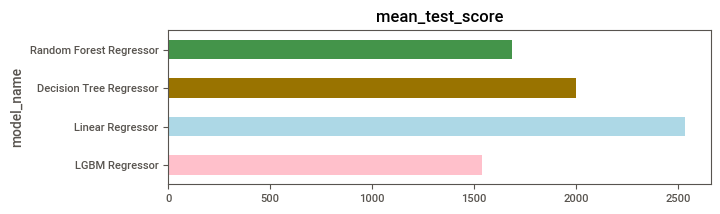

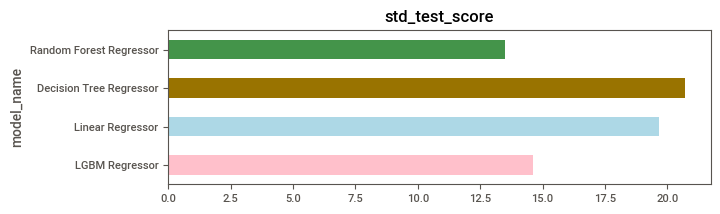

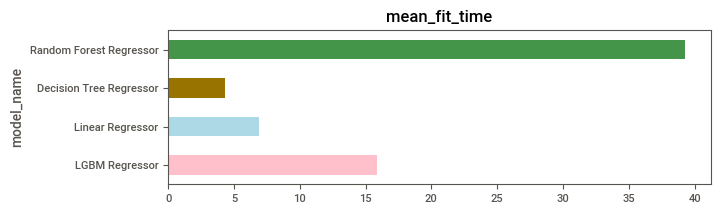

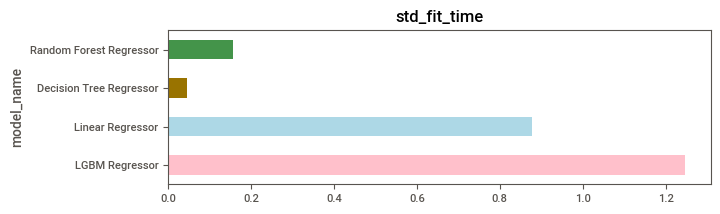

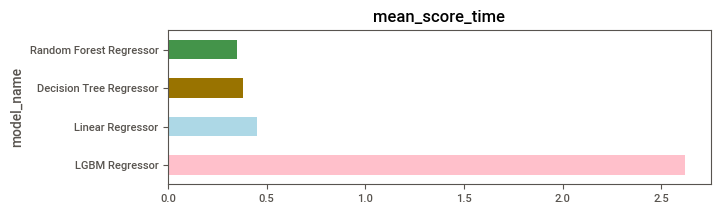

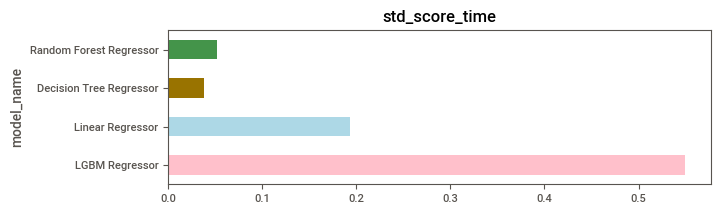

In [89]:
def show_models_results():
    [
        (
            models_results_df[["model_name", column]].plot(
                kind="barh",
                x="model_name",
                y=column,
                color=[
                    "pink",
                    "LightBlue",
                    "#997300",
                    "#44944a",
                    "violet",
                ],
                title=column,
                legend=None,
                figsize=(7, 2),
            ),
            plt.show(),
        )
        for column in [
            # "model_name",
            "mean_test_score",
            "std_test_score",
            "mean_fit_time",
            "std_fit_time",
            "mean_score_time",
            "std_score_time",
        ]
    ]
    print()


show_models_results()

### 1.7.1. Ускорение LightGBM Regressor

Ниже вручную подберем параметр n_estimators так, чтобы временные параметры LightGBM Regressor были не хуже чем у Decision Tree Regressor:

In [90]:
parameters = [
    {
        "model__estimator": [
            LGBMRegressor(learning_rate=0.17, n_estimators=40, random_state=19_12_22)
        ],
        # "model__estimator__n_estimators": list(range(300, 601, 20)),
        # "model__estimator__learning_rate": [x / 1000.0 for x in range(160, 180, 5)],
    },
]

In [91]:
rand_search_cv_lgbm2 = RandomizedSearchCV(
    pipeline,
    parameters,
    n_iter=1,
    cv=5,
    scoring=rmse_scorer,
    n_jobs=-1,
    random_state=19_12_22,
)

In [92]:
%%time
rand_search_cv_lgbm2.fit(X, y)
print()


CPU times: user 6.19 s, sys: 278 ms, total: 6.47 s
Wall time: 5.07 s


In [93]:
rand_search_cv_lgbm2.best_estimator_

Pipeline(steps=[('feature_creation_pipe',
                 Pipeline(steps=[('clip_reg_date',
                                  Winsorizer(tail='both',
                                             variables=['registration_year'])),
                                 ('add_date_parts',
                                  <__main__.DataframeFunctionTransformer object at 0x7f30710154f0>),
                                 ('add_yearly_km',
                                  <__main__.DataframeFunctionTransformer object at 0x7f3071015040>),
                                 ('add_regions',
                                  <__main__.DataframeFunctionTransformer objec...
                                                                                                 'fuel_type'])),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=nan)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('scaler',
                                                                   None)]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f3071015430>)])),
                ('model',
                 ModelSwitcher(estimator=LGBMRegressor(learning_rate=0.17,
                                                       n_estimators=40,
                                                       random_state=191222)))])

In [94]:
rand_search_cv_lgbm2.best_score_

-1695.389772652361

Выведем результаты с ускоренным LightGBM Regressor:

In [95]:
extract_result_from_gridsearch_cv(
    rand_search_cv_lgbm2, "LGBM Regressor faster", models_results
)

In [96]:
models_results_df = pd.DataFrame(models_results)
models_results_df

model_name                                              model  \
0           LGBM Regressor  ((Winsorizer(tail='both', variables=['registra...   
1         Linear Regressor  ((Winsorizer(tail='both', variables=['registra...   
2  Decision Tree Regressor  ((Winsorizer(tail='both', variables=['registra...   
3  Random Forest Regressor  ((Winsorizer(tail='both', variables=['registra...   
4    LGBM Regressor faster  ((Winsorizer(tail='both', variables=['registra...   

   mean_test_score  std_test_score  mean_fit_time  std_fit_time  \
0      1541.524693       14.606050      15.876132      1.246331   
1      2534.595553       19.658017       6.878259      0.878821   
2      1999.436412       20.699898       4.320852      0.045941   
3      1684.805204       13.513423      39.257544      0.157402   
4      1695.389773       17.096389       2.449063      0.057516   

   mean_score_time  std_score_time  \
0         2.620199        0.549204   
1         0.448166        0.193383   
2         0.379080        0.037639   
3         0.351312        0.051813   
4         0.359131        0.011256   

                                              params  
0  {'model__estimator__n_estimators': 600, 'model...  
1  {'transformer__num__scaler': StandardScaler(),...  
2  {'model__estimator__max_depth': 11, 'model__es...  
3  {'model__estimator__n_estimators': 49, 'model_...  
4  {'model__estimator': LGBMRegressor(learning_ra...

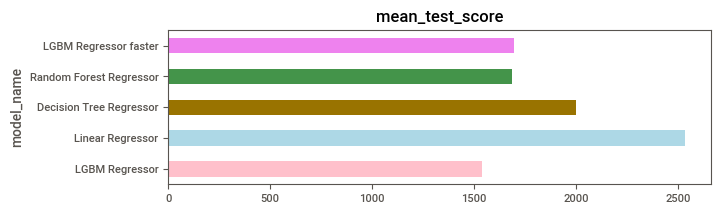

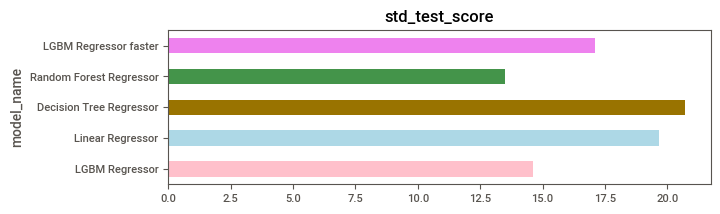

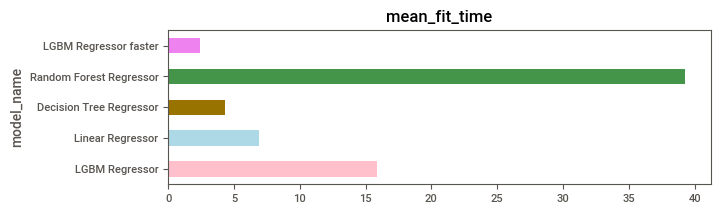

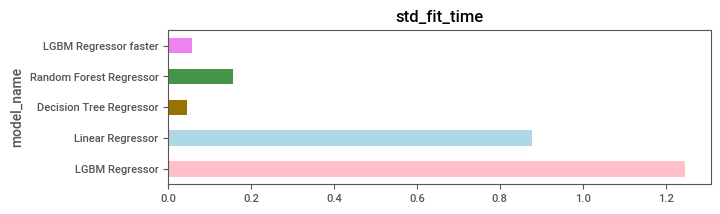

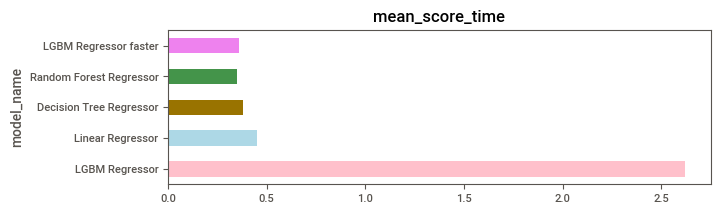

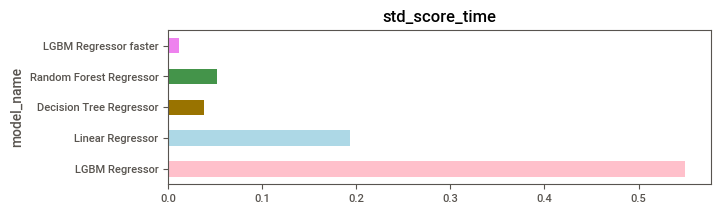

In [97]:
show_models_results()

<b>Вывод: </b>"Ускоренный" LightGBM Regressor показал лучшие метрики времени обучения и предсказания , чем Decision Tree Regressor, и в то же время его качество осталось на более высоком уровне чем у DTR. Таким образом, LightGBM Regressor в данном сравнении однозначный лидер. Для него можно подобрать параметры таким образом, чтобы он превосходил показатели всех остальных моделей.

### 1.7.2. Качество модели на тестовых данных

Получим значения RMSE метрики и времени предсказания на тестовых данных для двух наборов параметров LightGBM Regressor:

In [98]:
X_test = data_test.drop("price", axis=1)
y_test = data_test["price"]

In [99]:
X_train_original = data_train_original.drop("price", axis=1)
y_train_original = data_train_original["price"]

Время обучения на неподготовленных данных:

In [100]:
%%time
rand_search_cv_lgbm.best_estimator_.fit(X_train_original,y_train_original)
print()


CPU times: user 49.2 s, sys: 288 ms, total: 49.5 s
Wall time: 1min 51s


Время обучения:

In [101]:
%%time
rand_search_cv_lgbm.best_estimator_.fit(X,y)
print()


CPU times: user 47.5 s, sys: 217 ms, total: 47.7 s
Wall time: 4.34 s


Время предсказания:

In [102]:
%%time
y_pred=rand_search_cv_lgbm.best_estimator_.predict(X_test)

CPU times: user 3.5 s, sys: 377 µs, total: 3.5 s
Wall time: 3.81 s


RMSE:

In [103]:
mean_squared_error(
    y_test,
    y_pred,
    squared=False,
)

1979.5390940004822

____

<b>Для ускоренного LightGBM Regressor:</b>

Время обучения на неподготовленных данных:

In [104]:
%%time
rand_search_cv_lgbm2.best_estimator_.fit(X_train_original,y_train_original)
print()


CPU times: user 1min 19s, sys: 1.29 s, total: 1min 21s
Wall time: 2min 17s


Время обучения:

In [105]:
%%time
rand_search_cv_lgbm2.best_estimator_.fit(X,y)
print()


CPU times: user 4.8 s, sys: 214 ms, total: 5.01 s
Wall time: 1.71 s


Время предсказания:

In [106]:
%%time
y_pred=rand_search_cv_lgbm2.best_estimator_.predict(X_test)

CPU times: user 442 ms, sys: 0 ns, total: 442 ms
Wall time: 3.52 s


RMSE:

In [107]:
mean_squared_error(
    y_test,
    y_pred,
    squared=False,
)

1886.1023688160979

Получили значения RMSE метрик удовлетворяющие требованиям, а также видим, что облегченная по числу  estimator-ов версия работает в два раза быстрее, но выдает на тестовых данных значение RMSE метрики на ~100 единиц больше (хуже).

## 1.8. Выводы

Мы подобрали модель для опеределения стоимости автомобилей - LightGBM Regressor. Она превзошла все остальные модели (Random Forest Regressor, Decision Tree Regressor, Linear Regrssion) по метрике качества, а также сохраняет лидерство в RMSE-метрике при подборе параметров таким образом, чтобы превосходить все остальные модели также и по времени обучения и скорости предсказания.